In [18]:
!pip uninstall mediapipe -y


Found existing installation: mediapipe 0.10.21
Uninstalling mediapipe-0.10.21:
  Successfully uninstalled mediapipe-0.10.21


In [29]:
!pip uninstall -y numpy mediapipe seaborn pandas


Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
Found existing installation: seaborn 0.13.2
Uninstalling seaborn-0.13.2:
  Successfully uninstalled seaborn-0.13.2
Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3


In [3]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatib

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import random
import pandas as pd
import seaborn as sns
from collections import deque
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
import mediapipe as mp

In [5]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
all_classes = os.listdir('/content/drive/MyDrive/sign_lang_dataset')

In [8]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64,64
SEQUENCE_LEN = 30
DATASET_DIR = '/content/drive/MyDrive/sign_lang_dataset/'
CLASS_LIST = os.listdir('/content/drive/MyDrive/sign_lang_dataset')

In [7]:

# mp_holistic = mp.solutions.holistic
# mp_drawing = mp.solutions.drawing_utils

In [9]:
from tqdm import tqdm

In [10]:
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands

pose_model = mp_pose.Pose(static_image_mode=False)
hands_model = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

In [16]:
def pose_and_hand_landmark_extraction(video_path, pose_model, hands_model, sequence_length=30):
    cap = cv2.VideoCapture(video_path)
    video_frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    sequence = []
    print("Gonna start taking frames")
    for frame_num in range(sequence_length):
        if frame_num%10 == 0:
          print("Frame num - ",frame_num)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num * skip_frames_window)
        success, frame = cap.read()
        if not success:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        pose_results = pose_model.process(image)
        hand_results = hands_model.process(image)

        keypoints = []

        # Pose: shoulders, elbows, wrists
        pose_indices = [11, 12, 13, 14, 15, 16]
        if pose_results.pose_landmarks:
            for idx in pose_indices:
                lm = pose_results.pose_landmarks.landmark[idx]
                keypoints.extend([lm.x, lm.y, lm.z])
        else:
            keypoints.extend([0] * len(pose_indices) * 3)

        # Hands: left and right
        if hand_results.multi_hand_landmarks:
            for hand_landmarks in hand_results.multi_hand_landmarks:
                for lm in hand_landmarks.landmark:
                    keypoints.extend([lm.x, lm.y, lm.z])
            # If only one hand is found, add zeros for the second hand
            if len(hand_results.multi_hand_landmarks) == 1:
                keypoints.extend([0] * 21 * 3)
        else:
            # No hands detected
            keypoints.extend([0] * 21 * 3 * 2)

        if len(keypoints) == 144:
          sequence.append(keypoints)
        else:
          print(f"Warning: Skipped frame {frame_num} due to invalid keypoints length: {len(keypoints)}")


    cap.release()

    if len(sequence) == sequence_length:
        return np.array(sequence)
    else:
        return None

In [11]:
def create_dataset():
    features = []
    labels = []

    for class_name in tqdm(CLASS_LIST):
        print("Class - ", class_name)
        class_dir = os.path.join(DATASET_DIR, class_name)
        for file_name in os.listdir(class_dir):
            print("File - ", file_name)
            if not file_name.endswith('.mp4'):
                continue
            video_path = os.path.join(class_dir, file_name)
            sequence = pose_and_hand_landmark_extraction(video_path, pose_model, hands_model, SEQUENCE_LEN)
            if sequence is not None and sequence.shape == (SEQUENCE_LEN, 144):
                features.append(sequence)
                labels.append(class_name)
                print("Got valid seq")
            else:
                print(f"Skipped due to shape issue: {None if sequence is None else sequence.shape}")

    pose_model.close()
    hands_model.close()

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels

In [12]:
features, labels = create_dataset()
labels

  0%|          | 0/9 [00:00<?, ?it/s]

Class -  water
File -  1.mp4
Gonna start taking frames
Frame num -  0
Frame num -  10
Frame num -  20
Got valid seq
File -  2.mp4


  0%|          | 0/9 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [11]:
features = np.load('/content/drive/MyDrive/features.npy')
one_hot_labels = np.load('/content/drive/MyDrive/labels.npy')
one_hot_labels.shape

(520, 9)

In [26]:
label_map = {
    'water': 1,
    'i': 2,
    'food': 3,
    'want': 4,
    'hello': 5,
    'thanks': 6,
    'please': 7,
    'you': 8,
    'help': 9
}

numeric_labels = np.array([label_map[label.lower()] for label in labels])
numeric_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

In [27]:
one_hot_labels = to_categorical(numeric_labels - 1, num_classes=len(label_map))
one_hot_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [28]:
np.save('/content/drive/MyDrive/features.npy', features)
np.save('/content/drive/MyDrive/labels.npy', one_hot_labels)

Saved so that I dont have to run these again and again

In [15]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_labels, test_size=0.2, random_state=seed_constant, stratify = one_hot_labels.argmax(axis=1))

In [16]:
print(features_train.shape)
print(labels_train.shape)
print(features_test.shape)
print(labels_test.shape)

(416, 30, 144)
(416, 9)
(104, 30, 144)
(104, 9)


In [17]:
num_classes = one_hot_labels.shape[1]  # 9 ofc still keeping it like this so I can change num of classes later on and not worry about changing it everywhere

def create_model():
  model = Sequential()

  model.add(LSTM(64, return_sequences=True, input_shape=(30, 144)))
  model.add(Dropout(0.2))
  model.add(LSTM(64))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation='softmax'))

  model.summary()
  return model

In [39]:
sign_lang_model_1 = create_model()
print("Model Creation successfil")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        53,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,273 (356.54 KB)

 Trainable params: 91,273 (356.54 KB)

 Non-trainable params: 0 (0.00 B)

Model Creation successfil


In [40]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience=15, mode='min', restore_best_weights=True)
sign_lang_model_1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
sign_lang_model_1_history = sign_lang_model_1.fit(x=features_train, y=labels_train, epochs=70, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/70
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2281 - loss: 1.9708 - val_accuracy: 0.3452 - val_loss: 1.5298
Epoch 2/70
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3705 - loss: 1.4040 - val_accuracy: 0.3929 - val_loss: 1.3560
Epoch 3/70
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5072 - loss: 1.1804 - val_accuracy: 0.4286 - val_loss: 1.4924
Epoch 4/70
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4619 - loss: 1.2038 - val_accuracy: 0.6667 - val_loss: 0.9168
Epoch 5/70
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6478 - loss: 0.9257 - val_accuracy: 0.5357 - val_loss: 1.1058
Epoch 6/70
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6291 - loss: 0.9224 - val_accuracy: 0.7143 - val_loss: 0.7697
Epoch 7/70
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7017 - loss: 0.7628 - val_accuracy: 0.6667 - val_loss: 0.7601
Epoch 8/70
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7218 - loss: 0.6281 - val_accuracy: 0.7262 - v

In [41]:
model_evaluation_history = sign_lang_model_1.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8857 - loss: 0.2894 


In [12]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/sign_lang_model_1_best.h5'
sign_lang_model_loaded = load_model(model_path)

In [42]:
sign_lang_model_1.save('/content/drive/MyDrive/sign_lang_model_1_best.h5')

In [14]:
video_file = random.choice(os.listdir('/content/drive/MyDrive/SignVideos'))
test_video_file_path = '/content/drive/MyDrive/SignVideos/' + video_file
test_video_file_path

'/content/drive/MyDrive/SignVideos/1000065129.mp4'

In [17]:
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands

pose_model = mp_pose.Pose(static_image_mode=False)
hands_model = mp_hands.Hands(static_image_mode=False)

x = pose_and_hand_landmark_extraction(test_video_file_path, pose_model, hands_model, SEQUENCE_LEN)
x.shape

Gonna start taking frames
Frame num -  0
Frame num -  10
Frame num -  20


(30, 144)

In [18]:
pose_model.close()
hands_model.close()

In [19]:
k = sign_lang_model_loaded.predict(np.expand_dims(x,axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


In [20]:
k

array([[3.2699766e-04, 5.0850922e-01, 4.8575904e-03, 3.5971700e-04,
        1.8890643e-04, 4.5558818e-02, 4.3311131e-01, 6.3317651e-03,
        7.5563544e-04]], dtype=float32)

In [21]:
label_to_word = {
    0: 'water',
    1: 'I',
    2: 'food',
    3: 'want',
    4: 'Hello',
    5: 'Thanks',
    6: 'please',
    7: 'you',
    8: 'help'
}


In [22]:
label_to_word[np.argmax(k)]

'I'

In [3]:
from collections import deque
import cv2
import numpy as np
import time

SEQUENCE_LEN = 30
FPS = 15
frame_buffer = deque(maxlen=SEQUENCE_LEN)
predicted_label = "Waiting..."
last_prediction_time = time.time()

# Initialize webcam
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FPS, FPS)

# Check if webcam opened successfully
if not cap.isOpened():
    print("❌ ERROR: Could not open webcam.")
else:
    print("✅ Webcam opened successfully.")
    print("📷 Starting live sign prediction...")

# Function to extract keypoints from a frame
def extract_frame_landmarks(frame_rgb):
    keypoints = []

    pose_results = pose_model.process(frame_rgb)
    hands_results = hands_model.process(frame_rgb)

    pose_indices = [11, 12, 13, 14, 15, 16]
    if pose_results.pose_landmarks:
        for idx in pose_indices:
            lm = pose_results.pose_landmarks.landmark[idx]
            keypoints.extend([lm.x, lm.y, lm.z])
    else:
        keypoints.extend([0] * len(pose_indices) * 3)

    if hands_results.multi_hand_landmarks:
        for hand_landmarks in hands_results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
        if len(hands_results.multi_hand_landmarks) == 1:
            keypoints.extend([0] * 21 * 3)
    else:
        keypoints.extend([0] * 21 * 3 * 2)

    return keypoints if len(keypoints) == 144 else None

# Main loop
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("❌ ERROR: Failed to read frame.")
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    landmarks = extract_frame_landmarks(frame_rgb)

    if landmarks:
        frame_buffer.append(landmarks)

    # Predict every 2 seconds if 30 frames available
    if len(frame_buffer) == SEQUENCE_LEN and (time.time() - last_prediction_time) > 2:
        input_data = np.expand_dims(frame_buffer, axis=0)
        prediction = sign_lang_model_loaded.predict(input_data)
        predicted_label = class_names[np.argmax(prediction)]
        print(f"✅ Predicted: {predicted_label}")
        last_prediction_time = time.time()

    cv2.putText(frame, f'Sign: {predicted_label}', (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Live Sign Language Prediction', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


❌ ERROR: Could not open webcam.


In [ ]:
def pose_and_hand_landmark_extraction(video_path, pose_model, hands_model, sequence_length=30):
    cap = cv2.VideoCapture(video_path)
    video_frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    sequence = []
    print("Gonna start taking frames")
    for frame_num in range(sequence_length):
        if frame_num%10 == 0:
          print("Frame num - ",frame_num)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num * skip_frames_window)
        success, frame = cap.read()
        if not success:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        pose_results = pose_model.process(image)
        hand_results = hands_model.process(image)

        keypoints = []

        # Pose: shoulders, elbows, wrists
        pose_indices = [11, 12, 13, 14, 15, 16]
        if pose_results.pose_landmarks:
            for idx in pose_indices:
                lm = pose_results.pose_landmarks.landmark[idx]
                keypoints.extend([lm.x, lm.y, lm.z])
        else:
            keypoints.extend([0] * len(pose_indices) * 3)

        # Hands: left and right
        if hand_results.multi_hand_landmarks:
            for hand_landmarks in hand_results.multi_hand_landmarks:
                for lm in hand_landmarks.landmark:
                    keypoints.extend([lm.x, lm.y, lm.z])
            # If only one hand is found, add zeros for the second hand
            if len(hand_results.multi_hand_landmarks) == 1:
                keypoints.extend([0] * 21 * 3)
        else:
            # No hands detected
            keypoints.extend([0] * 21 * 3 * 2)

        if len(keypoints) == 144:
          sequence.append(keypoints)
        else:
          print(f"Warning: Skipped frame {frame_num} due to invalid keypoints length: {len(keypoints)}")


    cap.release()

    if len(sequence) == sequence_length:
        return np.array(sequence)
    else:
        return None

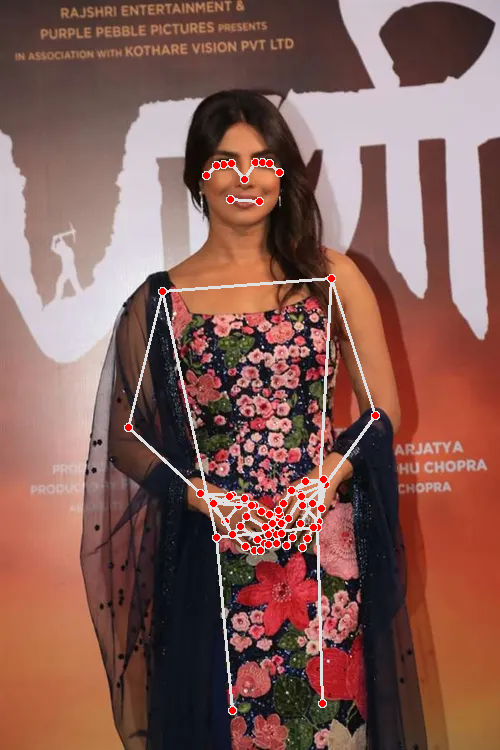

In [10]:
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

img = cv2.imread('/content/drive/MyDrive/test2.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = pose.process(img_rgb)

if results.pose_landmarks:
    mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2_imshow( img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No pose detected.")


In [ ]:
import cv2
import mediapipe as mp

holistic = mp.solutions.holistic.Holistic(static_image_mode=True)
cap = cv2.VideoCapture('/path/to/sample_video.mp4')
ret, frame = cap.read()
if ret:
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(image)
    if results.pose_landmarks:
        print("Pose landmarks detected")
    else:
        print("No pose detected")
holistic.close()


In [28]:
# import cv2
# import mediapipe as mp
# from google.colab.patches import cv2_imshow

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

# Initialize Holistic model
holistic = mp_holistic.Holistic(static_image_mode=True)

# Read and preprocess image
img = cv2.imread('/content/drive/MyDrive/test2.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Process the image
results = holistic.process(img_rgb)

# Check and draw available landmarks
landmarks_found = False

if results.face_landmarks:
    landmarks_found = True
    mp_drawing.draw_landmarks(
        img, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)

if results.left_hand_landmarks:
    landmarks_found = True
    mp_drawing.draw_landmarks(
        img, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

if results.right_hand_landmarks:
    landmarks_found = True
    mp_drawing.draw_landmarks(
        img, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

if results.pose_landmarks:
    landmarks_found = True
    mp_drawing.draw_landmarks(
        img, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)

if landmarks_found:
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No landmarks detected.")


RuntimeError: Failed to parse: node {
  name: "poselandmarkcpu__ImagePropertiesCalculator"
  calculator: "ImagePropertiesCalculator"
  input_stream: "IMAGE_CPU:image"
  output_stream: "SIZE:poselandmarkcpu__image_size"
}
node {
  name: "poselandmarkcpu__PreviousLoopbackCalculator"
  calculator: "PreviousLoopbackCalculator"
  input_stream: "MAIN:image"
  input_stream: "LOOP:pose_landmarks_roi"
  output_stream: "PREV_LOOP:poselandmarkcpu__prev_pose_rect_from_landmarks"
  input_stream_info {
    tag_index: "LOOP"
    back_edge: true
  }
}
node {
  name: "poselandmarkcpu__GateCalculator_1"
  calculator: "GateCalculator"
  input_stream: "poselandmarkcpu__prev_pose_rect_from_landmarks"
  output_stream: "poselandmarkcpu__gated_prev_pose_rect_from_landmarks"
  input_side_packet: "ALLOW:use_prev_landmarks"
  options {
    [mediapipe.GateCalculatorOptions.ext] {
      allow: true
    }
  }
}
node {
  name: "poselandmarkcpu__PacketPresenceCalculator"
  calculator: "PacketPresenceCalculator"
  input_stream: "PACKET:poselandmarkcpu__gated_prev_pose_rect_from_landmarks"
  output_stream: "PRESENCE:poselandmarkcpu__prev_pose_rect_from_landmarks_is_present"
}
node {
  name: "poselandmarkcpu__GateCalculator_2"
  calculator: "GateCalculator"
  input_stream: "image"
  input_stream: "poselandmarkcpu__image_size"
  input_stream: "DISALLOW:poselandmarkcpu__prev_pose_rect_from_landmarks_is_present"
  output_stream: "poselandmarkcpu__image_for_pose_detection"
  output_stream: "poselandmarkcpu__image_size_for_pose_detection"
  options {
    [mediapipe.GateCalculatorOptions.ext] {
      empty_packets_as_allow: true
    }
  }
}
node {
  name: "facelandmarksfromposecpu__ImagePropertiesCalculator"
  calculator: "ImagePropertiesCalculator"
  input_stream: "IMAGE:image"
  output_stream: "SIZE:facelandmarksfromposecpu__image_size"
}
node {
  name: "poselandmarkcpu__posedetectioncpu__ImageToTensorCalculator"
  calculator: "ImageToTensorCalculator"
  input_stream: "IMAGE:poselandmarkcpu__image_for_pose_detection"
  output_stream: "TENSORS:poselandmarkcpu__posedetectioncpu__input_tensors"
  output_stream: "LETTERBOX_PADDING:poselandmarkcpu__posedetectioncpu__letterbox_padding"
  options {
    [mediapipe.ImageToTensorCalculatorOptions.ext] {
      output_tensor_width: 224
      output_tensor_height: 224
      keep_aspect_ratio: true
      output_tensor_float_range {
        min: -1
        max: 1
      }
      gpu_origin: TOP_LEFT
      border_mode: BORDER_ZERO
    }
  }
}
node {
  name: "poselandmarkcpu__posedetectioncpu__SsdAnchorsCalculator"
  calculator: "SsdAnchorsCalculator"
  output_side_packet: "poselandmarkcpu__posedetectioncpu__anchors"
  options {
    [mediapipe.SsdAnchorsCalculatorOptions.ext] {
      input_size_width: 224
      input_size_height: 224
      min_scale: 0.1484375
      max_scale: 0.75
      anchor_offset_x: 0.5
      anchor_offset_y: 0.5
      num_layers: 5
      strides: 8
      strides: 16
      strides: 32
      strides: 32
      strides: 32
      aspect_ratios: 1
      fixed_anchor_size: true
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__ImagePropertiesCalculator"
  calculator: "ImagePropertiesCalculator"
  input_stream: "IMAGE_CPU:image"
  output_stream: "SIZE:poselandmarkcpu__poselandmarkbyroicpu__image_size"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__ImagePropertiesCalculator"
  calculator: "ImagePropertiesCalculator"
  input_stream: "IMAGE:image"
  output_stream: "SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__image_size"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__ImagePropertiesCalculator"
  calculator: "ImagePropertiesCalculator"
  input_stream: "IMAGE:image"
  output_stream: "SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__image_size"
}
node {
  name: "facelandmarksfromposecpu__facetracking__PreviousLoopbackCalculator"
  calculator: "PreviousLoopbackCalculator"
  input_stream: "MAIN:facelandmarksfromposecpu__image_size"
  input_stream: "LOOP:face_landmarks"
  output_stream: "PREV_LOOP:facelandmarksfromposecpu__facetracking__prev_face_landmarks"
  input_stream_info {
    tag_index: "LOOP"
    back_edge: true
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__TfLiteCustomOpResolverCalculator"
  calculator: "TfLiteCustomOpResolverCalculator"
  output_side_packet: "OP_RESOLVER:facelandmarksfromposecpu__facelandmarkcpu__op_resolver"
}
node {
  name: "poselandmarkcpu__posedetectioncpu__inferencecalculator__poselandmarkcpu__posedetectioncpu__InferenceCalculator"
  calculator: "InferenceCalculatorCpu"
  input_stream: "TENSORS:poselandmarkcpu__posedetectioncpu__input_tensors"
  output_stream: "TENSORS:poselandmarkcpu__posedetectioncpu__detection_tensors"
  options {
    [mediapipe.InferenceCalculatorOptions.ext] {
      model_path: "mediapipe/modules/pose_detection/pose_detection.tflite"
      delegate {
        xnnpack {
        }
      }
    }
  }
}
node {
  name: "poselandmarkcpu__posedetectioncpu__TensorsToDetectionsCalculator"
  calculator: "TensorsToDetectionsCalculator"
  input_stream: "TENSORS:poselandmarkcpu__posedetectioncpu__detection_tensors"
  output_stream: "DETECTIONS:poselandmarkcpu__posedetectioncpu__unfiltered_detections"
  input_side_packet: "ANCHORS:poselandmarkcpu__posedetectioncpu__anchors"
  options {
    [mediapipe.TensorsToDetectionsCalculatorOptions.ext] {
      num_classes: 1
      num_boxes: 2254
      num_coords: 12
      x_scale: 224
      y_scale: 224
      w_scale: 224
      h_scale: 224
      keypoint_coord_offset: 4
      num_keypoints: 4
      num_values_per_keypoint: 2
      box_coord_offset: 0
      reverse_output_order: true
      sigmoid_score: true
      score_clipping_thresh: 100
      min_score_thresh: 0.5
    }
  }
}
node {
  name: "poselandmarkcpu__posedetectioncpu__NonMaxSuppressionCalculator"
  calculator: "NonMaxSuppressionCalculator"
  input_stream: "poselandmarkcpu__posedetectioncpu__unfiltered_detections"
  output_stream: "poselandmarkcpu__posedetectioncpu__filtered_detections"
  options {
    [mediapipe.NonMaxSuppressionCalculatorOptions.ext] {
      min_suppression_threshold: 0.3
      overlap_type: INTERSECTION_OVER_UNION
      algorithm: WEIGHTED
    }
  }
}
node {
  name: "poselandmarkcpu__posedetectioncpu__DetectionLetterboxRemovalCalculator"
  calculator: "DetectionLetterboxRemovalCalculator"
  input_stream: "DETECTIONS:poselandmarkcpu__posedetectioncpu__filtered_detections"
  input_stream: "LETTERBOX_PADDING:poselandmarkcpu__posedetectioncpu__letterbox_padding"
  output_stream: "DETECTIONS:poselandmarkcpu__pose_detections"
}
node {
  name: "poselandmarkcpu__SplitDetectionVectorCalculator"
  calculator: "SplitDetectionVectorCalculator"
  input_stream: "poselandmarkcpu__pose_detections"
  output_stream: "pose_detection"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 0
        end: 1
      }
      element_only: true
    }
  }
}
node {
  name: "poselandmarkcpu__posedetectiontoroi__AlignmentPointsRectsCalculator"
  calculator: "AlignmentPointsRectsCalculator"
  input_stream: "DETECTION:pose_detection"
  input_stream: "IMAGE_SIZE:poselandmarkcpu__image_size_for_pose_detection"
  output_stream: "NORM_RECT:poselandmarkcpu__posedetectiontoroi__raw_roi"
  options {
    [mediapipe.DetectionsToRectsCalculatorOptions.ext] {
      rotation_vector_start_keypoint_index: 0
      rotation_vector_end_keypoint_index: 1
      rotation_vector_target_angle_degrees: 90
    }
  }
}
node {
  name: "poselandmarkcpu__posedetectiontoroi__RectTransformationCalculator"
  calculator: "RectTransformationCalculator"
  input_stream: "NORM_RECT:poselandmarkcpu__posedetectiontoroi__raw_roi"
  input_stream: "IMAGE_SIZE:poselandmarkcpu__image_size_for_pose_detection"
  output_stream: "poselandmarkcpu__pose_rect_from_detection"
  options {
    [mediapipe.RectTransformationCalculatorOptions.ext] {
      scale_x: 1.25
      scale_y: 1.25
      square_long: true
    }
  }
}
node {
  name: "poselandmarkcpu__MergeCalculator"
  calculator: "MergeCalculator"
  input_stream: "poselandmarkcpu__pose_rect_from_detection"
  input_stream: "poselandmarkcpu__gated_prev_pose_rect_from_landmarks"
  output_stream: "poselandmarkcpu__pose_rect"
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__ImageToTensorCalculator"
  calculator: "ImageToTensorCalculator"
  input_stream: "IMAGE:image"
  input_stream: "NORM_RECT:poselandmarkcpu__pose_rect"
  output_stream: "TENSORS:poselandmarkcpu__poselandmarkbyroicpu__input_tensors"
  output_stream: "LETTERBOX_PADDING:poselandmarkcpu__poselandmarkbyroicpu__letterbox_padding"
  output_stream: "MATRIX:poselandmarkcpu__poselandmarkbyroicpu__transformation_matrix"
  options {
    [mediapipe.ImageToTensorCalculatorOptions.ext] {
      output_tensor_width: 256
      output_tensor_height: 256
      keep_aspect_ratio: true
      output_tensor_float_range {
        min: 0
        max: 1
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__InverseMatrixCalculator"
  calculator: "InverseMatrixCalculator"
  input_stream: "MATRIX:poselandmarkcpu__poselandmarkbyroicpu__transformation_matrix"
  output_stream: "MATRIX:poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__inverse_transformation_matrix"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__ImagePropertiesCalculator"
  calculator: "ImagePropertiesCalculator"
  input_stream: "IMAGE:image"
  output_stream: "SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__image_size"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handtracking__PreviousLoopbackCalculator"
  calculator: "PreviousLoopbackCalculator"
  input_stream: "MAIN:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__image_size"
  input_stream: "LOOP:left_hand_landmarks"
  output_stream: "PREV_LOOP:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handtracking__prev_hand_landmarks"
  input_stream_info {
    tag_index: "LOOP"
    back_edge: true
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__ImagePropertiesCalculator"
  calculator: "ImagePropertiesCalculator"
  input_stream: "IMAGE:image"
  output_stream: "SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__image_size"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handtracking__PreviousLoopbackCalculator"
  calculator: "PreviousLoopbackCalculator"
  input_stream: "MAIN:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__image_size"
  input_stream: "LOOP:right_hand_landmarks"
  output_stream: "PREV_LOOP:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handtracking__prev_hand_landmarks"
  input_stream_info {
    tag_index: "LOOP"
    back_edge: true
  }
}
node {
  name: "facelandmarksfromposecpu__facetracking__facelandmarkstoroi__LandmarksToDetectionCalculator"
  calculator: "LandmarksToDetectionCalculator"
  input_stream: "NORM_LANDMARKS:facelandmarksfromposecpu__facetracking__prev_face_landmarks"
  output_stream: "DETECTION:facelandmarksfromposecpu__facetracking__facelandmarkstoroi__face_detection"
}
node {
  name: "facelandmarksfromposecpu__facetracking__facelandmarkstoroi__DetectionsToRectsCalculator"
  calculator: "DetectionsToRectsCalculator"
  input_stream: "DETECTION:facelandmarksfromposecpu__facetracking__facelandmarkstoroi__face_detection"
  input_stream: "IMAGE_SIZE:facelandmarksfromposecpu__image_size"
  output_stream: "NORM_RECT:facelandmarksfromposecpu__facetracking__facelandmarkstoroi__face_landmarks_rect_tight"
  options {
    [mediapipe.DetectionsToRectsCalculatorOptions.ext] {
      rotation_vector_start_keypoint_index: 33
      rotation_vector_end_keypoint_index: 263
      rotation_vector_target_angle_degrees: 0
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facetracking__facelandmarkstoroi__RectTransformationCalculator"
  calculator: "RectTransformationCalculator"
  input_stream: "NORM_RECT:facelandmarksfromposecpu__facetracking__facelandmarkstoroi__face_landmarks_rect_tight"
  input_stream: "IMAGE_SIZE:facelandmarksfromposecpu__image_size"
  output_stream: "facelandmarksfromposecpu__facetracking__prev_face_landmarks_rect"
  options {
    [mediapipe.RectTransformationCalculatorOptions.ext] {
      scale_x: 1.5
      scale_y: 1.5
      square_long: true
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__switchcontainer__SwitchDemuxCalculator"
  calculator: "SwitchDemuxCalculator"
  input_side_packet: "SELECT:model_complexity"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      select: 1
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__switchcontainer__ConstantSidePacketCalculator_1"
  calculator: "ConstantSidePacketCalculator"
  output_side_packet: "PACKET:poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__switchcontainer__c0__poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__model_path"
  options {
    [mediapipe.ConstantSidePacketCalculatorOptions.ext] {
      packet {
        string_value: "mediapipe/modules/pose_landmark/pose_landmark_lite.tflite"
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__switchcontainer__ConstantSidePacketCalculator_2"
  calculator: "ConstantSidePacketCalculator"
  output_side_packet: "PACKET:poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__switchcontainer__c1__poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__model_path"
  options {
    [mediapipe.ConstantSidePacketCalculatorOptions.ext] {
      packet {
        string_value: "mediapipe/modules/pose_landmark/pose_landmark_full.tflite"
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__switchcontainer__ConstantSidePacketCalculator_3"
  calculator: "ConstantSidePacketCalculator"
  output_side_packet: "PACKET:poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__switchcontainer__c2__poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__model_path"
  options {
    [mediapipe.ConstantSidePacketCalculatorOptions.ext] {
      packet {
        string_value: "mediapipe/modules/pose_landmark/pose_landmark_heavy.tflite"
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__switchcontainer__SwitchMuxCalculator"
  calculator: "SwitchMuxCalculator"
  input_side_packet: "SELECT:model_complexity"
  input_side_packet: "C0__PACKET:poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__switchcontainer__c0__poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__model_path"
  input_side_packet: "C1__PACKET:poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__switchcontainer__c1__poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__model_path"
  input_side_packet: "C2__PACKET:poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__switchcontainer__c2__poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__model_path"
  output_side_packet: "PACKET:poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__model_path"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      select: 1
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__ResourceProviderCalculator"
  calculator: "ResourceProviderCalculator"
  input_side_packet: "RESOURCE_ID:poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__model_path"
  output_side_packet: "RESOURCE:poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__model_resource"
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__TfLiteModelCalculator"
  calculator: "TfLiteModelCalculator"
  input_side_packet: "MODEL_RESOURCE:poselandmarkcpu__poselandmarkbyroicpu__poselandmarkmodelloader__model_resource"
  output_side_packet: "MODEL:poselandmarkcpu__poselandmarkbyroicpu__model"
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__inferencecalculator__poselandmarkcpu__poselandmarkbyroicpu__InferenceCalculator"
  calculator: "InferenceCalculatorCpu"
  input_stream: "TENSORS:poselandmarkcpu__poselandmarkbyroicpu__input_tensors"
  output_stream: "TENSORS:poselandmarkcpu__poselandmarkbyroicpu__output_tensors"
  input_side_packet: "MODEL:poselandmarkcpu__poselandmarkbyroicpu__model"
  options {
    [mediapipe.InferenceCalculatorOptions.ext] {
      delegate {
        xnnpack {
        }
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__SplitTensorVectorCalculator"
  calculator: "SplitTensorVectorCalculator"
  input_stream: "poselandmarkcpu__poselandmarkbyroicpu__output_tensors"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__landmark_tensor"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__pose_flag_tensor"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__segmentation_tensor"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__heatmap_tensor"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__world_landmark_tensor"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 0
        end: 1
      }
      ranges {
        begin: 1
        end: 2
      }
      ranges {
        begin: 2
        end: 3
      }
      ranges {
        begin: 3
        end: 4
      }
      ranges {
        begin: 4
        end: 5
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__TensorsToFloatsCalculator"
  calculator: "TensorsToFloatsCalculator"
  input_stream: "TENSORS:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__pose_flag_tensor"
  output_stream: "FLOAT:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__pose_presence_score"
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__ThresholdingCalculator"
  calculator: "ThresholdingCalculator"
  input_stream: "FLOAT:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__pose_presence_score"
  output_stream: "FLAG:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__pose_presence"
  options {
    [mediapipe.ThresholdingCalculatorOptions.ext] {
      threshold: 0.5
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__GateCalculator_1"
  calculator: "GateCalculator"
  input_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__landmark_tensor"
  input_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__world_landmark_tensor"
  input_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__segmentation_tensor"
  input_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__heatmap_tensor"
  input_stream: "ALLOW:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__pose_presence"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__ensured_landmark_tensor"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__ensured_world_landmark_tensor"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__ensured_segmentation_tensor"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__ensured_heatmap_tensor"
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__TensorsToLandmarksCalculator_1"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__ensured_landmark_tensor"
  output_stream: "NORM_LANDMARKS:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__raw_landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 39
      input_image_width: 256
      input_image_height: 256
      visibility_activation: SIGMOID
      presence_activation: SIGMOID
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__RefineLandmarksFromHeatmapCalculator"
  calculator: "RefineLandmarksFromHeatmapCalculator"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__raw_landmarks"
  input_stream: "TENSORS:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__ensured_heatmap_tensor"
  output_stream: "NORM_LANDMARKS:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__all_landmarks"
  options {
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__SplitNormalizedLandmarkListCalculator"
  calculator: "SplitNormalizedLandmarkListCalculator"
  input_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__all_landmarks"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__roi_landmarks"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__roi_auxiliary_landmarks"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 0
        end: 33
      }
      ranges {
        begin: 33
        end: 35
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__TensorsToLandmarksCalculator_2"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__ensured_world_landmark_tensor"
  output_stream: "LANDMARKS:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__all_world_landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 39
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__SplitLandmarkListCalculator"
  calculator: "SplitLandmarkListCalculator"
  input_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__all_world_landmarks"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__world_landmarks_without_visibility"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 0
        end: 33
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__VisibilityCopyCalculator"
  calculator: "VisibilityCopyCalculator"
  input_stream: "NORM_LANDMARKS_FROM:poselandmarkcpu__poselandmarkbyroicpu__roi_landmarks"
  input_stream: "LANDMARKS_TO:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__world_landmarks_without_visibility"
  output_stream: "LANDMARKS_TO:poselandmarkcpu__poselandmarkbyroicpu__roi_world_landmarks"
  options {
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__GateCalculator_2"
  calculator: "GateCalculator"
  input_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__ensured_segmentation_tensor"
  output_stream: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__enabled_segmentation_tensor"
  input_side_packet: "ALLOW:enable_segmentation"
  options {
    [mediapipe.GateCalculatorOptions.ext] {
      allow: false
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__TensorsToSegmentationCalculator"
  calculator: "TensorsToSegmentationCalculator"
  input_stream: "TENSORS:poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__enabled_segmentation_tensor"
  output_stream: "MASK:poselandmarkcpu__poselandmarkbyroicpu__roi_segmentation_mask"
  options {
    [mediapipe.TensorsToSegmentationCalculatorOptions.ext] {
      gpu_origin: TOP_LEFT
      activation: SIGMOID
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__LandmarkLetterboxRemovalCalculator_1"
  calculator: "LandmarkLetterboxRemovalCalculator"
  input_stream: "LANDMARKS:poselandmarkcpu__poselandmarkbyroicpu__roi_landmarks"
  input_stream: "LETTERBOX_PADDING:poselandmarkcpu__poselandmarkbyroicpu__letterbox_padding"
  output_stream: "LANDMARKS:poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__adjusted_landmarks"
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__LandmarkLetterboxRemovalCalculator_2"
  calculator: "LandmarkLetterboxRemovalCalculator"
  input_stream: "LANDMARKS:poselandmarkcpu__poselandmarkbyroicpu__roi_auxiliary_landmarks"
  input_stream: "LETTERBOX_PADDING:poselandmarkcpu__poselandmarkbyroicpu__letterbox_padding"
  output_stream: "LANDMARKS:poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__adjusted_auxiliary_landmarks"
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__LandmarkProjectionCalculator_1"
  calculator: "LandmarkProjectionCalculator"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__adjusted_landmarks"
  input_stream: "NORM_RECT:poselandmarkcpu__pose_rect"
  output_stream: "NORM_LANDMARKS:poselandmarkcpu__unfiltered_pose_landmarks"
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__LandmarkProjectionCalculator_2"
  calculator: "LandmarkProjectionCalculator"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__adjusted_auxiliary_landmarks"
  input_stream: "NORM_RECT:poselandmarkcpu__pose_rect"
  output_stream: "NORM_LANDMARKS:poselandmarkcpu__unfiltered_auxiliary_landmarks"
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__LandmarksToDetectionCalculator"
  calculator: "LandmarksToDetectionCalculator"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__unfiltered_auxiliary_landmarks"
  output_stream: "DETECTION:poselandmarkcpu__poselandmarkfiltering__aux_detection"
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__AlignmentPointsRectsCalculator"
  calculator: "AlignmentPointsRectsCalculator"
  input_stream: "DETECTION:poselandmarkcpu__poselandmarkfiltering__aux_detection"
  input_stream: "IMAGE_SIZE:poselandmarkcpu__image_size"
  output_stream: "NORM_RECT:poselandmarkcpu__poselandmarkfiltering__roi"
  options {
    [mediapipe.DetectionsToRectsCalculatorOptions.ext] {
      rotation_vector_start_keypoint_index: 0
      rotation_vector_end_keypoint_index: 1
      rotation_vector_target_angle_degrees: 90
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__VisibilitySmoothingCalculator"
  calculator: "VisibilitySmoothingCalculator"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__unfiltered_auxiliary_landmarks"
  output_stream: "NORM_FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__filtered_aux_visibility"
  options {
    [mediapipe.VisibilitySmoothingCalculatorOptions.ext] {
      low_pass_filter {
        alpha: 0.1
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__LandmarksSmoothingCalculator"
  calculator: "LandmarksSmoothingCalculator"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__filtered_aux_visibility"
  input_stream: "IMAGE_SIZE:poselandmarkcpu__image_size"
  input_stream: "OBJECT_SCALE_ROI:poselandmarkcpu__poselandmarkfiltering__roi"
  output_stream: "NORM_FILTERED_LANDMARKS:poselandmarkcpu__auxiliary_landmarks"
  options {
    [mediapipe.LandmarksSmoothingCalculatorOptions.ext] {
      one_euro_filter {
        min_cutoff: 0.01
        beta: 10
        derivate_cutoff: 1
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkstoroi__LandmarksToDetectionCalculator"
  calculator: "LandmarksToDetectionCalculator"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__auxiliary_landmarks"
  output_stream: "DETECTION:poselandmarkcpu__poselandmarkstoroi__detection"
}
node {
  name: "poselandmarkcpu__poselandmarkstoroi__AlignmentPointsRectsCalculator"
  calculator: "AlignmentPointsRectsCalculator"
  input_stream: "DETECTION:poselandmarkcpu__poselandmarkstoroi__detection"
  input_stream: "IMAGE_SIZE:poselandmarkcpu__image_size"
  output_stream: "NORM_RECT:poselandmarkcpu__poselandmarkstoroi__raw_roi"
  options {
    [mediapipe.DetectionsToRectsCalculatorOptions.ext] {
      rotation_vector_start_keypoint_index: 0
      rotation_vector_end_keypoint_index: 1
      rotation_vector_target_angle_degrees: 90
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkstoroi__RectTransformationCalculator"
  calculator: "RectTransformationCalculator"
  input_stream: "NORM_RECT:poselandmarkcpu__poselandmarkstoroi__raw_roi"
  input_stream: "IMAGE_SIZE:poselandmarkcpu__image_size"
  output_stream: "pose_landmarks_roi"
  options {
    [mediapipe.RectTransformationCalculatorOptions.ext] {
      scale_x: 1.25
      scale_y: 1.25
      square_long: true
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__WorldLandmarkProjectionCalculator"
  calculator: "WorldLandmarkProjectionCalculator"
  input_stream: "LANDMARKS:poselandmarkcpu__poselandmarkbyroicpu__roi_world_landmarks"
  input_stream: "NORM_RECT:poselandmarkcpu__pose_rect"
  output_stream: "LANDMARKS:poselandmarkcpu__unfiltered_world_landmarks"
}
node {
  name: "poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__WarpAffineCalculator"
  calculator: "WarpAffineCalculator"
  input_stream: "IMAGE:poselandmarkcpu__poselandmarkbyroicpu__roi_segmentation_mask"
  input_stream: "MATRIX:poselandmarkcpu__poselandmarkbyroicpu__poselandmarksandsegmentationinverseprojection__inverse_transformation_matrix"
  input_stream: "OUTPUT_SIZE:poselandmarkcpu__poselandmarkbyroicpu__image_size"
  output_stream: "IMAGE:poselandmarkcpu__unfiltered_segmentation_mask"
  options {
    [mediapipe.WarpAffineCalculatorOptions.ext] {
      border_mode: BORDER_ZERO
      gpu_origin: TOP_LEFT
    }
  }
}
node {
  name: "poselandmarkcpu__posesegmentationfiltering__PreviousLoopbackCalculator"
  calculator: "PreviousLoopbackCalculator"
  input_stream: "MAIN:poselandmarkcpu__unfiltered_segmentation_mask"
  input_stream: "LOOP:poselandmarkcpu__filtered_segmentation_mask"
  output_stream: "PREV_LOOP:poselandmarkcpu__posesegmentationfiltering__prev_filtered_segmentation_mask"
  input_stream_info {
    tag_index: "LOOP"
    back_edge: true
  }
}
node {
  name: "poselandmarkcpu__posesegmentationfiltering__GateCalculator"
  calculator: "GateCalculator"
  input_stream: "poselandmarkcpu__posesegmentationfiltering__prev_filtered_segmentation_mask"
  output_stream: "poselandmarkcpu__posesegmentationfiltering__gated_prev_filtered_segmentation_mask"
  input_side_packet: "ALLOW:smooth_segmentation"
  options {
    [mediapipe.GateCalculatorOptions.ext] {
      allow: true
    }
  }
}
node {
  name: "poselandmarkcpu__posesegmentationfiltering__SegmentationSmoothingCalculator"
  calculator: "SegmentationSmoothingCalculator"
  input_stream: "MASK:poselandmarkcpu__unfiltered_segmentation_mask"
  input_stream: "MASK_PREVIOUS:poselandmarkcpu__posesegmentationfiltering__gated_prev_filtered_segmentation_mask"
  output_stream: "MASK_SMOOTHED:poselandmarkcpu__filtered_segmentation_mask"
  options {
  }
}
node {
  name: "poselandmarkcpu__FromImageCalculator"
  calculator: "FromImageCalculator"
  input_stream: "IMAGE:poselandmarkcpu__filtered_segmentation_mask"
  output_stream: "IMAGE_CPU:segmentation_mask"
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_1__SwitchDemuxCalculator"
  calculator: "SwitchDemuxCalculator"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__unfiltered_pose_landmarks"
  output_stream: "C0__NORM_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_1__c0__poselandmarkcpu__unfiltered_pose_landmarks"
  output_stream: "C1__NORM_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_1__c1__poselandmarkcpu__unfiltered_pose_landmarks"
  input_side_packet: "ENABLE:smooth_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      enable: true
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_1__VisibilitySmoothingCalculator_1"
  calculator: "VisibilitySmoothingCalculator"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_1__c0__poselandmarkcpu__unfiltered_pose_landmarks"
  output_stream: "NORM_FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_1__c0__poselandmarkcpu__poselandmarkfiltering__filtered_visibility"
  options {
    [mediapipe.VisibilitySmoothingCalculatorOptions.ext] {
      no_filter {
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_1__VisibilitySmoothingCalculator_2"
  calculator: "VisibilitySmoothingCalculator"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_1__c1__poselandmarkcpu__unfiltered_pose_landmarks"
  output_stream: "NORM_FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_1__c1__poselandmarkcpu__poselandmarkfiltering__filtered_visibility"
  options {
    [mediapipe.VisibilitySmoothingCalculatorOptions.ext] {
      low_pass_filter {
        alpha: 0.1
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_1__SwitchMuxCalculator"
  calculator: "SwitchMuxCalculator"
  input_stream: "C0__NORM_FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_1__c0__poselandmarkcpu__poselandmarkfiltering__filtered_visibility"
  input_stream: "C1__NORM_FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_1__c1__poselandmarkcpu__poselandmarkfiltering__filtered_visibility"
  output_stream: "NORM_FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__filtered_visibility"
  input_side_packet: "ENABLE:smooth_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      enable: true
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__SwitchDemuxCalculator"
  calculator: "SwitchDemuxCalculator"
  input_stream: "IMAGE_SIZE:poselandmarkcpu__image_size"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__filtered_visibility"
  input_stream: "OBJECT_SCALE_ROI:poselandmarkcpu__poselandmarkfiltering__roi"
  output_stream: "C0__IMAGE_SIZE:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c0__poselandmarkcpu__image_size"
  output_stream: "C0__NORM_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c0__poselandmarkcpu__poselandmarkfiltering__filtered_visibility"
  output_stream: "C0__OBJECT_SCALE_ROI:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c0__poselandmarkcpu__poselandmarkfiltering__roi"
  output_stream: "C1__IMAGE_SIZE:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c1__poselandmarkcpu__image_size"
  output_stream: "C1__NORM_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c1__poselandmarkcpu__poselandmarkfiltering__filtered_visibility"
  output_stream: "C1__OBJECT_SCALE_ROI:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c1__poselandmarkcpu__poselandmarkfiltering__roi"
  input_side_packet: "ENABLE:smooth_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      enable: true
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__LandmarksSmoothingCalculator_1"
  calculator: "LandmarksSmoothingCalculator"
  input_stream: "IMAGE_SIZE:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c0__poselandmarkcpu__image_size"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c0__poselandmarkcpu__poselandmarkfiltering__filtered_visibility"
  input_stream: "OBJECT_SCALE_ROI:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c0__poselandmarkcpu__poselandmarkfiltering__roi"
  output_stream: "NORM_FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c0__pose_landmarks"
  options {
    [mediapipe.LandmarksSmoothingCalculatorOptions.ext] {
      no_filter {
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__LandmarksSmoothingCalculator_2"
  calculator: "LandmarksSmoothingCalculator"
  input_stream: "IMAGE_SIZE:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c1__poselandmarkcpu__image_size"
  input_stream: "NORM_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c1__poselandmarkcpu__poselandmarkfiltering__filtered_visibility"
  input_stream: "OBJECT_SCALE_ROI:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c1__poselandmarkcpu__poselandmarkfiltering__roi"
  output_stream: "NORM_FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c1__pose_landmarks"
  options {
    [mediapipe.LandmarksSmoothingCalculatorOptions.ext] {
      one_euro_filter {
        min_cutoff: 0.05
        beta: 80
        derivate_cutoff: 1
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__SwitchMuxCalculator"
  calculator: "SwitchMuxCalculator"
  input_stream: "C0__NORM_FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c0__pose_landmarks"
  input_stream: "C1__NORM_FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_2__c1__pose_landmarks"
  output_stream: "NORM_FILTERED_LANDMARKS:pose_landmarks"
  input_side_packet: "ENABLE:smooth_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      enable: true
    }
  }
}
node {
  calculator: "SplitNormalizedLandmarkListCalculator"
  input_stream: "pose_landmarks"
  output_stream: "face_landmarks_from_pose"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 0
        end: 11
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__SplitNormalizedLandmarkListCalculator_1"
  calculator: "SplitNormalizedLandmarkListCalculator"
  input_stream: "pose_landmarks"
  output_stream: "handlandmarksleftandrightcpu__left_hand_landmarks_from_pose"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 15
        end: 16
      }
      ranges {
        begin: 17
        end: 18
      }
      ranges {
        begin: 19
        end: 20
      }
      combine_outputs: true
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__SplitNormalizedLandmarkListCalculator_2"
  calculator: "SplitNormalizedLandmarkListCalculator"
  input_stream: "pose_landmarks"
  output_stream: "handlandmarksleftandrightcpu__right_hand_landmarks_from_pose"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 16
        end: 17
      }
      ranges {
        begin: 18
        end: 19
      }
      ranges {
        begin: 20
        end: 21
      }
      combine_outputs: true
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarksfromposetorecroproi__LandmarksToDetectionCalculator"
  calculator: "LandmarksToDetectionCalculator"
  input_stream: "NORM_LANDMARKS:face_landmarks_from_pose"
  output_stream: "DETECTION:facelandmarksfromposecpu__facelandmarksfromposetorecroproi__pose_face_detection"
}
node {
  name: "facelandmarksfromposecpu__facelandmarksfromposetorecroproi__DetectionsToRectsCalculator"
  calculator: "DetectionsToRectsCalculator"
  input_stream: "DETECTION:facelandmarksfromposecpu__facelandmarksfromposetorecroproi__pose_face_detection"
  input_stream: "IMAGE_SIZE:facelandmarksfromposecpu__image_size"
  output_stream: "NORM_RECT:facelandmarksfromposecpu__facelandmarksfromposetorecroproi__pose_face_rect"
  options {
    [mediapipe.DetectionsToRectsCalculatorOptions.ext] {
      rotation_vector_start_keypoint_index: 5
      rotation_vector_end_keypoint_index: 2
      rotation_vector_target_angle_degrees: 0
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarksfromposetorecroproi__RectTransformationCalculator"
  calculator: "RectTransformationCalculator"
  input_stream: "NORM_RECT:facelandmarksfromposecpu__facelandmarksfromposetorecroproi__pose_face_rect"
  input_stream: "IMAGE_SIZE:facelandmarksfromposecpu__image_size"
  output_stream: "facelandmarksfromposecpu__face_roi_from_pose"
  options {
    [mediapipe.RectTransformationCalculatorOptions.ext] {
      scale_x: 3
      scale_y: 3
      square_long: true
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_3__SwitchDemuxCalculator"
  calculator: "SwitchDemuxCalculator"
  input_stream: "LANDMARKS:poselandmarkcpu__unfiltered_world_landmarks"
  output_stream: "C0__LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_3__c0__poselandmarkcpu__unfiltered_world_landmarks"
  output_stream: "C1__LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_3__c1__poselandmarkcpu__unfiltered_world_landmarks"
  input_side_packet: "ENABLE:smooth_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      enable: true
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_3__VisibilitySmoothingCalculator_1"
  calculator: "VisibilitySmoothingCalculator"
  input_stream: "LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_3__c0__poselandmarkcpu__unfiltered_world_landmarks"
  output_stream: "FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_3__c0__poselandmarkcpu__poselandmarkfiltering__filtered_world_visibility"
  options {
    [mediapipe.VisibilitySmoothingCalculatorOptions.ext] {
      no_filter {
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_3__VisibilitySmoothingCalculator_2"
  calculator: "VisibilitySmoothingCalculator"
  input_stream: "LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_3__c1__poselandmarkcpu__unfiltered_world_landmarks"
  output_stream: "FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_3__c1__poselandmarkcpu__poselandmarkfiltering__filtered_world_visibility"
  options {
    [mediapipe.VisibilitySmoothingCalculatorOptions.ext] {
      low_pass_filter {
        alpha: 0.1
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_3__SwitchMuxCalculator"
  calculator: "SwitchMuxCalculator"
  input_stream: "C0__FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_3__c0__poselandmarkcpu__poselandmarkfiltering__filtered_world_visibility"
  input_stream: "C1__FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_3__c1__poselandmarkcpu__poselandmarkfiltering__filtered_world_visibility"
  output_stream: "FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__filtered_world_visibility"
  input_side_packet: "ENABLE:smooth_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      enable: true
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_4__SwitchDemuxCalculator"
  calculator: "SwitchDemuxCalculator"
  input_stream: "LANDMARKS:poselandmarkcpu__poselandmarkfiltering__filtered_world_visibility"
  output_stream: "C0__LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_4__c0__poselandmarkcpu__poselandmarkfiltering__filtered_world_visibility"
  output_stream: "C1__LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_4__c1__poselandmarkcpu__poselandmarkfiltering__filtered_world_visibility"
  input_side_packet: "ENABLE:smooth_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      enable: true
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_4__LandmarksSmoothingCalculator_1"
  calculator: "LandmarksSmoothingCalculator"
  input_stream: "LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_4__c0__poselandmarkcpu__poselandmarkfiltering__filtered_world_visibility"
  output_stream: "FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_4__c0__pose_world_landmarks"
  options {
    [mediapipe.LandmarksSmoothingCalculatorOptions.ext] {
      no_filter {
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_4__LandmarksSmoothingCalculator_2"
  calculator: "LandmarksSmoothingCalculator"
  input_stream: "LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_4__c1__poselandmarkcpu__poselandmarkfiltering__filtered_world_visibility"
  output_stream: "FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_4__c1__pose_world_landmarks"
  options {
    [mediapipe.LandmarksSmoothingCalculatorOptions.ext] {
      one_euro_filter {
        min_cutoff: 0.1
        beta: 40
        derivate_cutoff: 1
        disable_value_scaling: true
      }
    }
  }
}
node {
  name: "poselandmarkcpu__poselandmarkfiltering__switchcontainer_4__SwitchMuxCalculator"
  calculator: "SwitchMuxCalculator"
  input_stream: "C0__FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_4__c0__pose_world_landmarks"
  input_stream: "C1__FILTERED_LANDMARKS:poselandmarkcpu__poselandmarkfiltering__switchcontainer_4__c1__pose_world_landmarks"
  output_stream: "FILTERED_LANDMARKS:pose_world_landmarks"
  input_side_packet: "ENABLE:smooth_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      enable: true
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handvisibilityfromhandlandmarksfrompose__SplitNormalizedLandmarkListCalculator"
  calculator: "SplitNormalizedLandmarkListCalculator"
  input_stream: "handlandmarksleftandrightcpu__left_hand_landmarks_from_pose"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handvisibilityfromhandlandmarksfrompose__pose_wrist_landmark"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 0
        end: 1
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handvisibilityfromhandlandmarksfrompose__LandmarkVisibilityCalculator"
  calculator: "LandmarkVisibilityCalculator"
  input_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handvisibilityfromhandlandmarksfrompose__pose_wrist_landmark"
  output_stream: "VISIBILITY:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handvisibilityfromhandlandmarksfrompose__wrist_visibility_score"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handvisibilityfromhandlandmarksfrompose__ThresholdingCalculator"
  calculator: "ThresholdingCalculator"
  input_stream: "FLOAT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handvisibilityfromhandlandmarksfrompose__wrist_visibility_score"
  output_stream: "FLAG:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__hand_visibility"
  options {
    [mediapipe.ThresholdingCalculatorOptions.ext] {
      threshold: 0.1
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__GateCalculator"
  calculator: "GateCalculator"
  input_stream: "handlandmarksleftandrightcpu__left_hand_landmarks_from_pose"
  input_stream: "ALLOW:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__hand_visibility"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__ensured_hand_landmarks_from_pose"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarksfromposetorecroproi__LandmarksToDetectionCalculator"
  calculator: "LandmarksToDetectionCalculator"
  input_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__ensured_hand_landmarks_from_pose"
  output_stream: "DETECTION:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarksfromposetorecroproi__hand_detection_from_pose"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarksfromposetorecroproi__HandDetectionsFromPoseToRectsCalculator"
  calculator: "HandDetectionsFromPoseToRectsCalculator"
  input_stream: "DETECTION:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarksfromposetorecroproi__hand_detection_from_pose"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__image_size"
  output_stream: "NORM_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarksfromposetorecroproi__hand_roi_from_pose"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarksfromposetorecroproi__RectTransformationCalculator"
  calculator: "RectTransformationCalculator"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarksfromposetorecroproi__hand_roi_from_pose"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__image_size"
  output_stream: "handlandmarksleftandrightcpu__left_hand_roi_from_pose"
  options {
    [mediapipe.RectTransformationCalculatorOptions.ext] {
      scale_x: 2.7
      scale_y: 2.7
      shift_y: -0.1
      square_long: true
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__ImageToTensorCalculator"
  calculator: "ImageToTensorCalculator"
  input_stream: "IMAGE:image"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__left_hand_roi_from_pose"
  output_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__initial_crop_tensor"
  output_stream: "LETTERBOX_PADDING:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__letterbox_padding"
  options {
    [mediapipe.ImageToTensorCalculatorOptions.ext] {
      output_tensor_width: 256
      output_tensor_height: 256
      keep_aspect_ratio: true
      output_tensor_float_range {
        min: 0
        max: 1
      }
      gpu_origin: TOP_LEFT
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handvisibilityfromhandlandmarksfrompose__SplitNormalizedLandmarkListCalculator"
  calculator: "SplitNormalizedLandmarkListCalculator"
  input_stream: "handlandmarksleftandrightcpu__right_hand_landmarks_from_pose"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handvisibilityfromhandlandmarksfrompose__pose_wrist_landmark"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 0
        end: 1
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handvisibilityfromhandlandmarksfrompose__LandmarkVisibilityCalculator"
  calculator: "LandmarkVisibilityCalculator"
  input_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handvisibilityfromhandlandmarksfrompose__pose_wrist_landmark"
  output_stream: "VISIBILITY:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handvisibilityfromhandlandmarksfrompose__wrist_visibility_score"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handvisibilityfromhandlandmarksfrompose__ThresholdingCalculator"
  calculator: "ThresholdingCalculator"
  input_stream: "FLOAT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handvisibilityfromhandlandmarksfrompose__wrist_visibility_score"
  output_stream: "FLAG:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__hand_visibility"
  options {
    [mediapipe.ThresholdingCalculatorOptions.ext] {
      threshold: 0.1
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__GateCalculator"
  calculator: "GateCalculator"
  input_stream: "handlandmarksleftandrightcpu__right_hand_landmarks_from_pose"
  input_stream: "ALLOW:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__hand_visibility"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__ensured_hand_landmarks_from_pose"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarksfromposetorecroproi__LandmarksToDetectionCalculator"
  calculator: "LandmarksToDetectionCalculator"
  input_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__ensured_hand_landmarks_from_pose"
  output_stream: "DETECTION:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarksfromposetorecroproi__hand_detection_from_pose"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarksfromposetorecroproi__HandDetectionsFromPoseToRectsCalculator"
  calculator: "HandDetectionsFromPoseToRectsCalculator"
  input_stream: "DETECTION:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarksfromposetorecroproi__hand_detection_from_pose"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__image_size"
  output_stream: "NORM_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarksfromposetorecroproi__hand_roi_from_pose"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarksfromposetorecroproi__RectTransformationCalculator"
  calculator: "RectTransformationCalculator"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarksfromposetorecroproi__hand_roi_from_pose"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__image_size"
  output_stream: "handlandmarksleftandrightcpu__right_hand_roi_from_pose"
  options {
    [mediapipe.RectTransformationCalculatorOptions.ext] {
      scale_x: 2.7
      scale_y: 2.7
      shift_y: -0.1
      square_long: true
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__ImageToTensorCalculator"
  calculator: "ImageToTensorCalculator"
  input_stream: "IMAGE:image"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__right_hand_roi_from_pose"
  output_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__initial_crop_tensor"
  output_stream: "LETTERBOX_PADDING:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__letterbox_padding"
  options {
    [mediapipe.ImageToTensorCalculatorOptions.ext] {
      output_tensor_width: 256
      output_tensor_height: 256
      keep_aspect_ratio: true
      output_tensor_float_range {
        min: 0
        max: 1
      }
      gpu_origin: TOP_LEFT
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__inferencecalculator__handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__InferenceCalculator"
  calculator: "InferenceCalculatorCpu"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__initial_crop_tensor"
  output_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__landmark_tensors"
  options {
    [mediapipe.InferenceCalculatorOptions.ext] {
      model_path: "mediapipe/modules/holistic_landmark/hand_recrop.tflite"
      delegate {
        xnnpack {
        }
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__TensorsToLandmarksCalculator"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__landmark_tensors"
  output_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 2
      input_image_width: 256
      input_image_height: 256
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__LandmarkLetterboxRemovalCalculator"
  calculator: "LandmarkLetterboxRemovalCalculator"
  input_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__landmarks"
  input_stream: "LETTERBOX_PADDING:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__letterbox_padding"
  output_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__scaled_landmarks"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__LandmarkProjectionCalculator"
  calculator: "LandmarkProjectionCalculator"
  input_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__scaled_landmarks"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__left_hand_roi_from_pose"
  output_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__alignment_landmarks"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__LandmarksToDetectionCalculator"
  calculator: "LandmarksToDetectionCalculator"
  input_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__alignment_landmarks"
  output_stream: "DETECTION:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__hand_detection"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__AlignmentPointsRectsCalculator"
  calculator: "AlignmentPointsRectsCalculator"
  input_stream: "DETECTION:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__hand_detection"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__image_size"
  output_stream: "NORM_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__hand_roi_from_recrop"
  options {
    [mediapipe.DetectionsToRectsCalculatorOptions.ext] {
      rotation_vector_start_keypoint_index: 0
      rotation_vector_end_keypoint_index: 1
      rotation_vector_target_angle_degrees: -90
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__RectTransformationCalculator"
  calculator: "RectTransformationCalculator"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__hand_roi_from_recrop"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handrecropbyroicpu__image_size"
  output_stream: "handlandmarksleftandrightcpu__left_hand_roi_from_recrop"
  options {
    [mediapipe.RectTransformationCalculatorOptions.ext] {
      scale_x: 1
      scale_y: 1
      shift_y: -0.1
      square_long: true
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handtracking__handlandmarkstoroi__HandLandmarksToRectCalculator"
  calculator: "HandLandmarksToRectCalculator"
  input_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handtracking__prev_hand_landmarks"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__image_size"
  output_stream: "NORM_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handtracking__handlandmarkstoroi__palm_landmarks_rect"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handtracking__handlandmarkstoroi__RectTransformationCalculator"
  calculator: "RectTransformationCalculator"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handtracking__handlandmarkstoroi__palm_landmarks_rect"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__image_size"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handtracking__prev_hand_landmarks_roi"
  options {
    [mediapipe.RectTransformationCalculatorOptions.ext] {
      scale_x: 2
      scale_y: 2
      shift_y: -0.1
      square_long: true
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handtracking__RoiTrackingCalculator"
  calculator: "RoiTrackingCalculator"
  input_stream: "PREV_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handtracking__prev_hand_landmarks"
  input_stream: "PREV_LANDMARKS_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handtracking__prev_hand_landmarks_roi"
  input_stream: "RECROP_RECT:handlandmarksleftandrightcpu__left_hand_roi_from_recrop"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__image_size"
  output_stream: "TRACKING_RECT:handlandmarksleftandrightcpu__left_hand_tracking_roi"
  options {
    [mediapipe.RoiTrackingCalculatorOptions.ext] {
      rect_requirements {
        rotation_degrees: 40
        translation: 0.2
        scale: 0.4
      }
      landmarks_requirements {
        recrop_rect_margin: -0.1
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__ImageToTensorCalculator"
  calculator: "ImageToTensorCalculator"
  input_stream: "IMAGE:image"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__left_hand_tracking_roi"
  output_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__input_tensor"
  output_stream: "LETTERBOX_PADDING:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__letterbox_padding"
  options {
    [mediapipe.ImageToTensorCalculatorOptions.ext] {
      output_tensor_width: 224
      output_tensor_height: 224
      keep_aspect_ratio: true
      output_tensor_float_range {
        min: 0
        max: 1
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__inferencecalculator__handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__InferenceCalculator"
  calculator: "InferenceCalculatorCpu"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__initial_crop_tensor"
  output_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__landmark_tensors"
  options {
    [mediapipe.InferenceCalculatorOptions.ext] {
      model_path: "mediapipe/modules/holistic_landmark/hand_recrop.tflite"
      delegate {
        xnnpack {
        }
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__TensorsToLandmarksCalculator"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__landmark_tensors"
  output_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 2
      input_image_width: 256
      input_image_height: 256
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__LandmarkLetterboxRemovalCalculator"
  calculator: "LandmarkLetterboxRemovalCalculator"
  input_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__landmarks"
  input_stream: "LETTERBOX_PADDING:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__letterbox_padding"
  output_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__scaled_landmarks"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__LandmarkProjectionCalculator"
  calculator: "LandmarkProjectionCalculator"
  input_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__scaled_landmarks"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__right_hand_roi_from_pose"
  output_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__alignment_landmarks"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__LandmarksToDetectionCalculator"
  calculator: "LandmarksToDetectionCalculator"
  input_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__alignment_landmarks"
  output_stream: "DETECTION:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__hand_detection"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__AlignmentPointsRectsCalculator"
  calculator: "AlignmentPointsRectsCalculator"
  input_stream: "DETECTION:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__hand_detection"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__image_size"
  output_stream: "NORM_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__hand_roi_from_recrop"
  options {
    [mediapipe.DetectionsToRectsCalculatorOptions.ext] {
      rotation_vector_start_keypoint_index: 0
      rotation_vector_end_keypoint_index: 1
      rotation_vector_target_angle_degrees: -90
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__RectTransformationCalculator"
  calculator: "RectTransformationCalculator"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__hand_roi_from_recrop"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handrecropbyroicpu__image_size"
  output_stream: "handlandmarksleftandrightcpu__right_hand_roi_from_recrop"
  options {
    [mediapipe.RectTransformationCalculatorOptions.ext] {
      scale_x: 1
      scale_y: 1
      shift_y: -0.1
      square_long: true
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handtracking__handlandmarkstoroi__HandLandmarksToRectCalculator"
  calculator: "HandLandmarksToRectCalculator"
  input_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handtracking__prev_hand_landmarks"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__image_size"
  output_stream: "NORM_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handtracking__handlandmarkstoroi__palm_landmarks_rect"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handtracking__handlandmarkstoroi__RectTransformationCalculator"
  calculator: "RectTransformationCalculator"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handtracking__handlandmarkstoroi__palm_landmarks_rect"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__image_size"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handtracking__prev_hand_landmarks_roi"
  options {
    [mediapipe.RectTransformationCalculatorOptions.ext] {
      scale_x: 2
      scale_y: 2
      shift_y: -0.1
      square_long: true
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handtracking__RoiTrackingCalculator"
  calculator: "RoiTrackingCalculator"
  input_stream: "PREV_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handtracking__prev_hand_landmarks"
  input_stream: "PREV_LANDMARKS_RECT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handtracking__prev_hand_landmarks_roi"
  input_stream: "RECROP_RECT:handlandmarksleftandrightcpu__right_hand_roi_from_recrop"
  input_stream: "IMAGE_SIZE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__image_size"
  output_stream: "TRACKING_RECT:handlandmarksleftandrightcpu__right_hand_tracking_roi"
  options {
    [mediapipe.RoiTrackingCalculatorOptions.ext] {
      rect_requirements {
        rotation_degrees: 40
        translation: 0.2
        scale: 0.4
      }
      landmarks_requirements {
        recrop_rect_margin: -0.1
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__ImageToTensorCalculator"
  calculator: "ImageToTensorCalculator"
  input_stream: "IMAGE:image"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__right_hand_tracking_roi"
  output_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__input_tensor"
  output_stream: "LETTERBOX_PADDING:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__letterbox_padding"
  options {
    [mediapipe.ImageToTensorCalculatorOptions.ext] {
      output_tensor_width: 224
      output_tensor_height: 224
      keep_aspect_ratio: true
      output_tensor_float_range {
        min: 0
        max: 1
      }
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__ToImageCalculator"
  calculator: "ToImageCalculator"
  input_stream: "IMAGE:image"
  output_stream: "IMAGE:facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__multi_backend_image"
}
node {
  name: "facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__ImageToTensorCalculator"
  calculator: "ImageToTensorCalculator"
  input_stream: "IMAGE:facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__multi_backend_image"
  input_stream: "NORM_RECT:facelandmarksfromposecpu__face_roi_from_pose"
  output_stream: "TENSORS:facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__input_tensors"
  output_stream: "MATRIX:facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__transform_matrix"
  node_options {
    type_url: "type.googleapis.com/mediapipe.ImageToTensorCalculatorOptions"
    value: "\030\001"\n\r\000\000\200\277\025\000\000\200?0\001\010\200\001\020\200\001"
  }
}
node {
  name: "facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__SsdAnchorsCalculator"
  calculator: "SsdAnchorsCalculator"
  output_side_packet: "facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__anchors"
  node_options {
    type_url: "type.googleapis.com/mediapipe.SsdAnchorsCalculatorOptions"
    value: "\035\000\000\030>%\000\000@?-\000\000\000?5\000\000\000?]\000\000\200?p\001\010\200\001\020\200\0018\004P\010P\020P\020P\020m\000\000\200?"
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__switchcontainer__SwitchDemuxCalculator"
  calculator: "SwitchDemuxCalculator"
  input_side_packet: "ENABLE:refine_face_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__switchcontainer__ConstantSidePacketCalculator_1"
  calculator: "ConstantSidePacketCalculator"
  output_side_packet: "PACKET:facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__switchcontainer__c0__facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__model_path"
  options {
    [mediapipe.ConstantSidePacketCalculatorOptions.ext] {
      packet {
        string_value: "mediapipe/modules/face_landmark/face_landmark.tflite"
      }
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__switchcontainer__ConstantSidePacketCalculator_2"
  calculator: "ConstantSidePacketCalculator"
  output_side_packet: "PACKET:facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__switchcontainer__c1__facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__model_path"
  options {
    [mediapipe.ConstantSidePacketCalculatorOptions.ext] {
      packet {
        string_value: "mediapipe/modules/face_landmark/face_landmark_with_attention.tflite"
      }
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__switchcontainer__SwitchMuxCalculator"
  calculator: "SwitchMuxCalculator"
  input_side_packet: "ENABLE:refine_face_landmarks"
  input_side_packet: "C0__PACKET:facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__switchcontainer__c0__facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__model_path"
  input_side_packet: "C1__PACKET:facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__switchcontainer__c1__facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__model_path"
  output_side_packet: "PACKET:facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__model_path"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__ResourceProviderCalculator"
  calculator: "ResourceProviderCalculator"
  input_side_packet: "RESOURCE_ID:facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__model_path"
  output_side_packet: "RESOURCE:facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__model_resource"
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__TfLiteModelCalculator"
  calculator: "TfLiteModelCalculator"
  input_side_packet: "MODEL_RESOURCE:facelandmarksfromposecpu__facelandmarkcpu__facelandmarksmodelloader__model_resource"
  output_side_packet: "MODEL:facelandmarksfromposecpu__facelandmarkcpu__model"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__SwitchDemuxCalculator"
  calculator: "SwitchDemuxCalculator"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      select: 1
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__ConstantSidePacketCalculator_1"
  calculator: "ConstantSidePacketCalculator"
  output_side_packet: "PACKET:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__c0__handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__model_path"
  options {
    [mediapipe.ConstantSidePacketCalculatorOptions.ext] {
      packet {
        string_value: "mediapipe/modules/hand_landmark/hand_landmark_lite.tflite"
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__ConstantSidePacketCalculator_2"
  calculator: "ConstantSidePacketCalculator"
  output_side_packet: "PACKET:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__c1__handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__model_path"
  options {
    [mediapipe.ConstantSidePacketCalculatorOptions.ext] {
      packet {
        string_value: "mediapipe/modules/hand_landmark/hand_landmark_full.tflite"
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__SwitchMuxCalculator"
  calculator: "SwitchMuxCalculator"
  input_side_packet: "C0__PACKET:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__c0__handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__model_path"
  input_side_packet: "C1__PACKET:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__c1__handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__model_path"
  output_side_packet: "PACKET:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__model_path"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      select: 1
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__ResourceProviderCalculator"
  calculator: "ResourceProviderCalculator"
  input_side_packet: "RESOURCE_ID:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__model_path"
  output_side_packet: "RESOURCE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__model_resource"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__TfLiteModelCalculator"
  calculator: "TfLiteModelCalculator"
  input_side_packet: "MODEL_RESOURCE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handlandmarkmodelloader__model_resource"
  output_side_packet: "MODEL:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__model"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__inferencecalculator__handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__InferenceCalculator"
  calculator: "InferenceCalculatorCpu"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__input_tensor"
  output_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__output_tensors"
  input_side_packet: "MODEL:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__model"
  options {
    [mediapipe.InferenceCalculatorOptions.ext] {
      delegate {
        xnnpack {
        }
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__SplitTensorVectorCalculator"
  calculator: "SplitTensorVectorCalculator"
  input_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__output_tensors"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__landmark_tensors"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__hand_flag_tensor"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handedness_tensor"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__world_landmark_tensor"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 0
        end: 1
      }
      ranges {
        begin: 1
        end: 2
      }
      ranges {
        begin: 2
        end: 3
      }
      ranges {
        begin: 3
        end: 4
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__TensorsToFloatsCalculator"
  calculator: "TensorsToFloatsCalculator"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__hand_flag_tensor"
  output_stream: "FLOAT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__hand_presence_score"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__ThresholdingCalculator"
  calculator: "ThresholdingCalculator"
  input_stream: "FLOAT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__hand_presence_score"
  output_stream: "FLAG:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__hand_presence"
  options {
    [mediapipe.ThresholdingCalculatorOptions.ext] {
      threshold: 0.5
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__GateCalculator_1"
  calculator: "GateCalculator"
  input_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handedness_tensor"
  input_stream: "ALLOW:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__hand_presence"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__ensured_handedness_tensor"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__TensorsToClassificationCalculator"
  calculator: "TensorsToClassificationCalculator"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__ensured_handedness_tensor"
  output_stream: "CLASSIFICATIONS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__handedness"
  options {
    [mediapipe.TensorsToClassificationCalculatorOptions.ext] {
      top_k: 1
      label_map_path: "mediapipe/modules/hand_landmark/handedness.txt"
      binary_classification: true
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__GateCalculator_2"
  calculator: "GateCalculator"
  input_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__landmark_tensors"
  input_stream: "ALLOW:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__hand_presence"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__ensured_landmark_tensors"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__TensorsToLandmarksCalculator_1"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__ensured_landmark_tensors"
  output_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 21
      input_image_width: 224
      input_image_height: 224
      normalize_z: 0.4
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__LandmarkLetterboxRemovalCalculator"
  calculator: "LandmarkLetterboxRemovalCalculator"
  input_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__landmarks"
  input_stream: "LETTERBOX_PADDING:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__letterbox_padding"
  output_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__scaled_landmarks"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__LandmarkProjectionCalculator"
  calculator: "LandmarkProjectionCalculator"
  input_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__scaled_landmarks"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__left_hand_tracking_roi"
  output_stream: "NORM_LANDMARKS:left_hand_landmarks"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__GateCalculator_3"
  calculator: "GateCalculator"
  input_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__world_landmark_tensor"
  input_stream: "ALLOW:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__hand_presence"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__ensured_world_landmark_tensor"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__TensorsToLandmarksCalculator_2"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__ensured_world_landmark_tensor"
  output_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__unprojected_world_landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 21
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__WorldLandmarkProjectionCalculator"
  calculator: "WorldLandmarkProjectionCalculator"
  input_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__unprojected_world_landmarks"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__left_hand_tracking_roi"
  output_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_1__handlandmarkcpu__hand_world_landmarks"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__SwitchDemuxCalculator"
  calculator: "SwitchDemuxCalculator"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      select: 1
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__ConstantSidePacketCalculator_1"
  calculator: "ConstantSidePacketCalculator"
  output_side_packet: "PACKET:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__c0__handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__model_path"
  options {
    [mediapipe.ConstantSidePacketCalculatorOptions.ext] {
      packet {
        string_value: "mediapipe/modules/hand_landmark/hand_landmark_lite.tflite"
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__ConstantSidePacketCalculator_2"
  calculator: "ConstantSidePacketCalculator"
  output_side_packet: "PACKET:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__c1__handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__model_path"
  options {
    [mediapipe.ConstantSidePacketCalculatorOptions.ext] {
      packet {
        string_value: "mediapipe/modules/hand_landmark/hand_landmark_full.tflite"
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__SwitchMuxCalculator"
  calculator: "SwitchMuxCalculator"
  input_side_packet: "C0__PACKET:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__c0__handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__model_path"
  input_side_packet: "C1__PACKET:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__switchcontainer__c1__handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__model_path"
  output_side_packet: "PACKET:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__model_path"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
      select: 1
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__ResourceProviderCalculator"
  calculator: "ResourceProviderCalculator"
  input_side_packet: "RESOURCE_ID:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__model_path"
  output_side_packet: "RESOURCE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__model_resource"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__TfLiteModelCalculator"
  calculator: "TfLiteModelCalculator"
  input_side_packet: "MODEL_RESOURCE:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handlandmarkmodelloader__model_resource"
  output_side_packet: "MODEL:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__model"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__inferencecalculator__handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__InferenceCalculator"
  calculator: "InferenceCalculatorCpu"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__input_tensor"
  output_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__output_tensors"
  input_side_packet: "MODEL:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__model"
  options {
    [mediapipe.InferenceCalculatorOptions.ext] {
      delegate {
        xnnpack {
        }
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__SplitTensorVectorCalculator"
  calculator: "SplitTensorVectorCalculator"
  input_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__output_tensors"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__landmark_tensors"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__hand_flag_tensor"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handedness_tensor"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__world_landmark_tensor"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 0
        end: 1
      }
      ranges {
        begin: 1
        end: 2
      }
      ranges {
        begin: 2
        end: 3
      }
      ranges {
        begin: 3
        end: 4
      }
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__TensorsToFloatsCalculator"
  calculator: "TensorsToFloatsCalculator"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__hand_flag_tensor"
  output_stream: "FLOAT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__hand_presence_score"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__ThresholdingCalculator"
  calculator: "ThresholdingCalculator"
  input_stream: "FLOAT:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__hand_presence_score"
  output_stream: "FLAG:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__hand_presence"
  options {
    [mediapipe.ThresholdingCalculatorOptions.ext] {
      threshold: 0.5
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__GateCalculator_1"
  calculator: "GateCalculator"
  input_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handedness_tensor"
  input_stream: "ALLOW:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__hand_presence"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__ensured_handedness_tensor"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__TensorsToClassificationCalculator"
  calculator: "TensorsToClassificationCalculator"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__ensured_handedness_tensor"
  output_stream: "CLASSIFICATIONS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__handedness"
  options {
    [mediapipe.TensorsToClassificationCalculatorOptions.ext] {
      top_k: 1
      label_map_path: "mediapipe/modules/hand_landmark/handedness.txt"
      binary_classification: true
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__GateCalculator_2"
  calculator: "GateCalculator"
  input_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__landmark_tensors"
  input_stream: "ALLOW:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__hand_presence"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__ensured_landmark_tensors"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__TensorsToLandmarksCalculator_1"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__ensured_landmark_tensors"
  output_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 21
      input_image_width: 224
      input_image_height: 224
      normalize_z: 0.4
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__LandmarkLetterboxRemovalCalculator"
  calculator: "LandmarkLetterboxRemovalCalculator"
  input_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__landmarks"
  input_stream: "LETTERBOX_PADDING:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__letterbox_padding"
  output_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__scaled_landmarks"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__LandmarkProjectionCalculator"
  calculator: "LandmarkProjectionCalculator"
  input_stream: "NORM_LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__scaled_landmarks"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__right_hand_tracking_roi"
  output_stream: "NORM_LANDMARKS:right_hand_landmarks"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__GateCalculator_3"
  calculator: "GateCalculator"
  input_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__world_landmark_tensor"
  input_stream: "ALLOW:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__hand_presence"
  output_stream: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__ensured_world_landmark_tensor"
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__TensorsToLandmarksCalculator_2"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__ensured_world_landmark_tensor"
  output_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__unprojected_world_landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 21
    }
  }
}
node {
  name: "handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__WorldLandmarkProjectionCalculator"
  calculator: "WorldLandmarkProjectionCalculator"
  input_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__unprojected_world_landmarks"
  input_stream: "NORM_RECT:handlandmarksleftandrightcpu__right_hand_tracking_roi"
  output_stream: "LANDMARKS:handlandmarksleftandrightcpu__handlandmarksfromposecpu_2__handlandmarkcpu__hand_world_landmarks"
}
node {
  name: "facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__inferencecalculator__facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__InferenceCalculator"
  calculator: "InferenceCalculatorCpu"
  input_stream: "TENSORS:facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__input_tensors"
  output_stream: "TENSORS:facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__detection_tensors"
  node_options {
    type_url: "type.googleapis.com/mediapipe.InferenceCalculatorOptions"
    value: "*\002"\000\nBmediapipe/modules/face_detection/face_detection_short_range.tflite"
  }
}
node {
  name: "facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__TensorsToDetectionsCalculator"
  calculator: "TensorsToDetectionsCalculator"
  input_stream: "TENSORS:facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__detection_tensors"
  output_stream: "DETECTIONS:facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__unfiltered_detections"
  input_side_packet: "ANCHORS:facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__anchors"
  node_options {
    type_url: "type.googleapis.com/mediapipe.TensorsToDetectionsCalculatorOptions"
    value: "\010\001\030\020H\004P\006X\002`\000p\001x\001\205\001\000\000\310B\020\200\007%\000\000\000C-\000\000\000C=\000\000\000C5\000\000\000C\235\001\000\000\000?"
  }
}
node {
  name: "facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__NonMaxSuppressionCalculator"
  calculator: "NonMaxSuppressionCalculator"
  input_stream: "facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__unfiltered_detections"
  output_stream: "facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__filtered_detections"
  options {
    [mediapipe.NonMaxSuppressionCalculatorOptions.ext] {
      min_suppression_threshold: 0.3
      overlap_type: INTERSECTION_OVER_UNION
      algorithm: WEIGHTED
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__DetectionProjectionCalculator"
  calculator: "DetectionProjectionCalculator"
  input_stream: "DETECTIONS:facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__filtered_detections"
  input_stream: "PROJECTION_MATRIX:facelandmarksfromposecpu__facedetectionshortrangebyroicpu__facedetectionshortrange__facedetection__transform_matrix"
  output_stream: "DETECTIONS:facelandmarksfromposecpu__face_detections"
}
node {
  name: "facelandmarksfromposecpu__facedetectionfrontdetectionstoroi__DetectionsToRectsCalculator"
  calculator: "DetectionsToRectsCalculator"
  input_stream: "DETECTIONS:facelandmarksfromposecpu__face_detections"
  input_stream: "IMAGE_SIZE:facelandmarksfromposecpu__image_size"
  output_stream: "NORM_RECT:facelandmarksfromposecpu__facedetectionfrontdetectionstoroi__raw_roi"
  options {
    [mediapipe.DetectionsToRectsCalculatorOptions.ext] {
      rotation_vector_start_keypoint_index: 0
      rotation_vector_end_keypoint_index: 1
      rotation_vector_target_angle_degrees: 0
      conversion_mode: USE_KEYPOINTS
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facedetectionfrontdetectionstoroi__RectTransformationCalculator"
  calculator: "RectTransformationCalculator"
  input_stream: "NORM_RECT:facelandmarksfromposecpu__facedetectionfrontdetectionstoroi__raw_roi"
  input_stream: "IMAGE_SIZE:facelandmarksfromposecpu__image_size"
  output_stream: "facelandmarksfromposecpu__face_roi_from_detection"
  options {
    [mediapipe.RectTransformationCalculatorOptions.ext] {
      scale_x: 2
      scale_y: 2
      shift_y: -0.1
      square_long: true
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facetracking__RoiTrackingCalculator"
  calculator: "RoiTrackingCalculator"
  input_stream: "PREV_LANDMARKS:facelandmarksfromposecpu__facetracking__prev_face_landmarks"
  input_stream: "PREV_LANDMARKS_RECT:facelandmarksfromposecpu__facetracking__prev_face_landmarks_rect"
  input_stream: "RECROP_RECT:facelandmarksfromposecpu__face_roi_from_detection"
  input_stream: "IMAGE_SIZE:facelandmarksfromposecpu__image_size"
  output_stream: "TRACKING_RECT:facelandmarksfromposecpu__face_tracking_roi"
  options {
    [mediapipe.RoiTrackingCalculatorOptions.ext] {
      rect_requirements {
        rotation_degrees: 15
        translation: 0.1
        scale: 0.3
      }
      landmarks_requirements {
        recrop_rect_margin: -0.2
      }
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__ImageToTensorCalculator"
  calculator: "ImageToTensorCalculator"
  input_stream: "IMAGE:image"
  input_stream: "NORM_RECT:facelandmarksfromposecpu__face_tracking_roi"
  output_stream: "TENSORS:facelandmarksfromposecpu__facelandmarkcpu__input_tensors"
  options {
    [mediapipe.ImageToTensorCalculatorOptions.ext] {
      output_tensor_width: 192
      output_tensor_height: 192
      output_tensor_float_range {
        min: 0
        max: 1
      }
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__inferencecalculator__facelandmarksfromposecpu__facelandmarkcpu__InferenceCalculator"
  calculator: "InferenceCalculatorCpu"
  input_stream: "TENSORS:facelandmarksfromposecpu__facelandmarkcpu__input_tensors"
  output_stream: "TENSORS:facelandmarksfromposecpu__facelandmarkcpu__output_tensors"
  input_side_packet: "MODEL:facelandmarksfromposecpu__facelandmarkcpu__model"
  input_side_packet: "OP_RESOLVER:facelandmarksfromposecpu__facelandmarkcpu__op_resolver"
  options {
    [mediapipe.InferenceCalculatorOptions.ext] {
      delegate {
        xnnpack {
        }
      }
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__SwitchDemuxCalculator"
  calculator: "SwitchDemuxCalculator"
  input_stream: "facelandmarksfromposecpu__facelandmarkcpu__output_tensors"
  output_stream: "C0__:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__c0__facelandmarksfromposecpu__facelandmarkcpu__output_tensors"
  output_stream: "C1__:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__c1__facelandmarksfromposecpu__facelandmarkcpu__output_tensors"
  input_side_packet: "ENABLE:refine_face_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__SplitTensorVectorCalculator_1"
  calculator: "SplitTensorVectorCalculator"
  input_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__c0__facelandmarksfromposecpu__facelandmarkcpu__output_tensors"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__c0__facelandmarksfromposecpu__facelandmarkcpu__landmark_tensors"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__c0__facelandmarksfromposecpu__facelandmarkcpu__face_flag_tensor"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 0
        end: 1
      }
      ranges {
        begin: 1
        end: 2
      }
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__SplitTensorVectorCalculator_2"
  calculator: "SplitTensorVectorCalculator"
  input_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__c1__facelandmarksfromposecpu__facelandmarkcpu__output_tensors"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__c1__facelandmarksfromposecpu__facelandmarkcpu__landmark_tensors"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__c1__facelandmarksfromposecpu__facelandmarkcpu__face_flag_tensor"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 0
        end: 6
      }
      ranges {
        begin: 6
        end: 7
      }
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__SwitchMuxCalculator"
  calculator: "SwitchMuxCalculator"
  input_stream: "C0__:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__c0__facelandmarksfromposecpu__facelandmarkcpu__landmark_tensors"
  input_stream: "C0__:1:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__c0__facelandmarksfromposecpu__facelandmarkcpu__face_flag_tensor"
  input_stream: "C1__:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__c1__facelandmarksfromposecpu__facelandmarkcpu__landmark_tensors"
  input_stream: "C1__:1:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_1__c1__facelandmarksfromposecpu__facelandmarkcpu__face_flag_tensor"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__landmark_tensors"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__face_flag_tensor"
  input_side_packet: "ENABLE:refine_face_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__TensorsToFloatsCalculator"
  calculator: "TensorsToFloatsCalculator"
  input_stream: "TENSORS:facelandmarksfromposecpu__facelandmarkcpu__face_flag_tensor"
  output_stream: "FLOAT:facelandmarksfromposecpu__facelandmarkcpu__face_presence_score"
  options {
    [mediapipe.TensorsToFloatsCalculatorOptions.ext] {
      activation: SIGMOID
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__ThresholdingCalculator"
  calculator: "ThresholdingCalculator"
  input_stream: "FLOAT:facelandmarksfromposecpu__facelandmarkcpu__face_presence_score"
  output_stream: "FLAG:facelandmarksfromposecpu__facelandmarkcpu__face_presence"
  options {
    [mediapipe.ThresholdingCalculatorOptions.ext] {
      threshold: 0.5
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__GateCalculator"
  calculator: "GateCalculator"
  input_stream: "facelandmarksfromposecpu__facelandmarkcpu__landmark_tensors"
  input_stream: "ALLOW:facelandmarksfromposecpu__facelandmarkcpu__face_presence"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__ensured_landmark_tensors"
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__SwitchDemuxCalculator"
  calculator: "SwitchDemuxCalculator"
  input_stream: "TENSORS:facelandmarksfromposecpu__facelandmarkcpu__ensured_landmark_tensors"
  output_stream: "C0__TENSORS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__c0__facelandmarksfromposecpu__facelandmarkcpu__ensured_landmark_tensors"
  output_stream: "C1__TENSORS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__c1__facelandmarksfromposecpu__facelandmarkcpu__ensured_landmark_tensors"
  input_side_packet: "ENABLE:refine_face_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarks__TensorsToLandmarksCalculator"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__c0__facelandmarksfromposecpu__facelandmarkcpu__ensured_landmark_tensors"
  output_stream: "NORM_LANDMARKS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__c0__facelandmarksfromposecpu__facelandmarkcpu__landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 468
      input_image_width: 192
      input_image_height: 192
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__SplitTensorVectorCalculator"
  calculator: "SplitTensorVectorCalculator"
  input_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__c1__facelandmarksfromposecpu__facelandmarkcpu__ensured_landmark_tensors"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__mesh_tensor"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__lips_tensor"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__left_eye_tensor"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__right_eye_tensor"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__left_iris_tensor"
  output_stream: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__right_iris_tensor"
  options {
    [mediapipe.SplitVectorCalculatorOptions.ext] {
      ranges {
        begin: 0
        end: 1
      }
      ranges {
        begin: 1
        end: 2
      }
      ranges {
        begin: 2
        end: 3
      }
      ranges {
        begin: 3
        end: 4
      }
      ranges {
        begin: 4
        end: 5
      }
      ranges {
        begin: 5
        end: 6
      }
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__TensorsToLandmarksCalculator_1"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__mesh_tensor"
  output_stream: "NORM_LANDMARKS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__mesh_landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 468
      input_image_width: 192
      input_image_height: 192
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__TensorsToLandmarksCalculator_2"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__lips_tensor"
  output_stream: "NORM_LANDMARKS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__lips_landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 80
      input_image_width: 192
      input_image_height: 192
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__TensorsToLandmarksCalculator_3"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__left_eye_tensor"
  output_stream: "NORM_LANDMARKS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__left_eye_landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 71
      input_image_width: 192
      input_image_height: 192
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__TensorsToLandmarksCalculator_4"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__right_eye_tensor"
  output_stream: "NORM_LANDMARKS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__right_eye_landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 71
      input_image_width: 192
      input_image_height: 192
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__TensorsToLandmarksCalculator_5"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__left_iris_tensor"
  output_stream: "NORM_LANDMARKS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__left_iris_landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 5
      input_image_width: 192
      input_image_height: 192
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__TensorsToLandmarksCalculator_6"
  calculator: "TensorsToLandmarksCalculator"
  input_stream: "TENSORS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__right_iris_tensor"
  output_stream: "NORM_LANDMARKS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__right_iris_landmarks"
  options {
    [mediapipe.TensorsToLandmarksCalculatorOptions.ext] {
      num_landmarks: 5
      input_image_width: 192
      input_image_height: 192
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__LandmarksRefinementCalculator"
  calculator: "LandmarksRefinementCalculator"
  input_stream: "LANDMARKS:0:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__mesh_landmarks"
  input_stream: "LANDMARKS:1:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__lips_landmarks"
  input_stream: "LANDMARKS:2:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__left_eye_landmarks"
  input_stream: "LANDMARKS:3:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__right_eye_landmarks"
  input_stream: "LANDMARKS:4:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__left_iris_landmarks"
  input_stream: "LANDMARKS:5:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__tensorstofacelandmarkswithattention__right_iris_landmarks"
  output_stream: "REFINED_LANDMARKS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__c1__facelandmarksfromposecpu__facelandmarkcpu__landmarks"
  options {
    [mediapipe.LandmarksRefinementCalculatorOptions.ext] {
      refinement {
        indexes_mapping: 0
        indexes_mapping: 1
        indexes_mapping: 2
        indexes_mapping: 3
        indexes_mapping: 4
        indexes_mapping: 5
        indexes_mapping: 6
        indexes_mapping: 7
        indexes_mapping: 8
        indexes_mapping: 9
        indexes_mapping: 10
        indexes_mapping: 11
        indexes_mapping: 12
        indexes_mapping: 13
        indexes_mapping: 14
        indexes_mapping: 15
        indexes_mapping: 16
        indexes_mapping: 17
        indexes_mapping: 18
        indexes_mapping: 19
        indexes_mapping: 20
        indexes_mapping: 21
        indexes_mapping: 22
        indexes_mapping: 23
        indexes_mapping: 24
        indexes_mapping: 25
        indexes_mapping: 26
        indexes_mapping: 27
        indexes_mapping: 28
        indexes_mapping: 29
        indexes_mapping: 30
        indexes_mapping: 31
        indexes_mapping: 32
        indexes_mapping: 33
        indexes_mapping: 34
        indexes_mapping: 35
        indexes_mapping: 36
        indexes_mapping: 37
        indexes_mapping: 38
        indexes_mapping: 39
        indexes_mapping: 40
        indexes_mapping: 41
        indexes_mapping: 42
        indexes_mapping: 43
        indexes_mapping: 44
        indexes_mapping: 45
        indexes_mapping: 46
        indexes_mapping: 47
        indexes_mapping: 48
        indexes_mapping: 49
        indexes_mapping: 50
        indexes_mapping: 51
        indexes_mapping: 52
        indexes_mapping: 53
        indexes_mapping: 54
        indexes_mapping: 55
        indexes_mapping: 56
        indexes_mapping: 57
        indexes_mapping: 58
        indexes_mapping: 59
        indexes_mapping: 60
        indexes_mapping: 61
        indexes_mapping: 62
        indexes_mapping: 63
        indexes_mapping: 64
        indexes_mapping: 65
        indexes_mapping: 66
        indexes_mapping: 67
        indexes_mapping: 68
        indexes_mapping: 69
        indexes_mapping: 70
        indexes_mapping: 71
        indexes_mapping: 72
        indexes_mapping: 73
        indexes_mapping: 74
        indexes_mapping: 75
        indexes_mapping: 76
        indexes_mapping: 77
        indexes_mapping: 78
        indexes_mapping: 79
        indexes_mapping: 80
        indexes_mapping: 81
        indexes_mapping: 82
        indexes_mapping: 83
        indexes_mapping: 84
        indexes_mapping: 85
        indexes_mapping: 86
        indexes_mapping: 87
        indexes_mapping: 88
        indexes_mapping: 89
        indexes_mapping: 90
        indexes_mapping: 91
        indexes_mapping: 92
        indexes_mapping: 93
        indexes_mapping: 94
        indexes_mapping: 95
        indexes_mapping: 96
        indexes_mapping: 97
        indexes_mapping: 98
        indexes_mapping: 99
        indexes_mapping: 100
        indexes_mapping: 101
        indexes_mapping: 102
        indexes_mapping: 103
        indexes_mapping: 104
        indexes_mapping: 105
        indexes_mapping: 106
        indexes_mapping: 107
        indexes_mapping: 108
        indexes_mapping: 109
        indexes_mapping: 110
        indexes_mapping: 111
        indexes_mapping: 112
        indexes_mapping: 113
        indexes_mapping: 114
        indexes_mapping: 115
        indexes_mapping: 116
        indexes_mapping: 117
        indexes_mapping: 118
        indexes_mapping: 119
        indexes_mapping: 120
        indexes_mapping: 121
        indexes_mapping: 122
        indexes_mapping: 123
        indexes_mapping: 124
        indexes_mapping: 125
        indexes_mapping: 126
        indexes_mapping: 127
        indexes_mapping: 128
        indexes_mapping: 129
        indexes_mapping: 130
        indexes_mapping: 131
        indexes_mapping: 132
        indexes_mapping: 133
        indexes_mapping: 134
        indexes_mapping: 135
        indexes_mapping: 136
        indexes_mapping: 137
        indexes_mapping: 138
        indexes_mapping: 139
        indexes_mapping: 140
        indexes_mapping: 141
        indexes_mapping: 142
        indexes_mapping: 143
        indexes_mapping: 144
        indexes_mapping: 145
        indexes_mapping: 146
        indexes_mapping: 147
        indexes_mapping: 148
        indexes_mapping: 149
        indexes_mapping: 150
        indexes_mapping: 151
        indexes_mapping: 152
        indexes_mapping: 153
        indexes_mapping: 154
        indexes_mapping: 155
        indexes_mapping: 156
        indexes_mapping: 157
        indexes_mapping: 158
        indexes_mapping: 159
        indexes_mapping: 160
        indexes_mapping: 161
        indexes_mapping: 162
        indexes_mapping: 163
        indexes_mapping: 164
        indexes_mapping: 165
        indexes_mapping: 166
        indexes_mapping: 167
        indexes_mapping: 168
        indexes_mapping: 169
        indexes_mapping: 170
        indexes_mapping: 171
        indexes_mapping: 172
        indexes_mapping: 173
        indexes_mapping: 174
        indexes_mapping: 175
        indexes_mapping: 176
        indexes_mapping: 177
        indexes_mapping: 178
        indexes_mapping: 179
        indexes_mapping: 180
        indexes_mapping: 181
        indexes_mapping: 182
        indexes_mapping: 183
        indexes_mapping: 184
        indexes_mapping: 185
        indexes_mapping: 186
        indexes_mapping: 187
        indexes_mapping: 188
        indexes_mapping: 189
        indexes_mapping: 190
        indexes_mapping: 191
        indexes_mapping: 192
        indexes_mapping: 193
        indexes_mapping: 194
        indexes_mapping: 195
        indexes_mapping: 196
        indexes_mapping: 197
        indexes_mapping: 198
        indexes_mapping: 199
        indexes_mapping: 200
        indexes_mapping: 201
        indexes_mapping: 202
        indexes_mapping: 203
        indexes_mapping: 204
        indexes_mapping: 205
        indexes_mapping: 206
        indexes_mapping: 207
        indexes_mapping: 208
        indexes_mapping: 209
        indexes_mapping: 210
        indexes_mapping: 211
        indexes_mapping: 212
        indexes_mapping: 213
        indexes_mapping: 214
        indexes_mapping: 215
        indexes_mapping: 216
        indexes_mapping: 217
        indexes_mapping: 218
        indexes_mapping: 219
        indexes_mapping: 220
        indexes_mapping: 221
        indexes_mapping: 222
        indexes_mapping: 223
        indexes_mapping: 224
        indexes_mapping: 225
        indexes_mapping: 226
        indexes_mapping: 227
        indexes_mapping: 228
        indexes_mapping: 229
        indexes_mapping: 230
        indexes_mapping: 231
        indexes_mapping: 232
        indexes_mapping: 233
        indexes_mapping: 234
        indexes_mapping: 235
        indexes_mapping: 236
        indexes_mapping: 237
        indexes_mapping: 238
        indexes_mapping: 239
        indexes_mapping: 240
        indexes_mapping: 241
        indexes_mapping: 242
        indexes_mapping: 243
        indexes_mapping: 244
        indexes_mapping: 245
        indexes_mapping: 246
        indexes_mapping: 247
        indexes_mapping: 248
        indexes_mapping: 249
        indexes_mapping: 250
        indexes_mapping: 251
        indexes_mapping: 252
        indexes_mapping: 253
        indexes_mapping: 254
        indexes_mapping: 255
        indexes_mapping: 256
        indexes_mapping: 257
        indexes_mapping: 258
        indexes_mapping: 259
        indexes_mapping: 260
        indexes_mapping: 261
        indexes_mapping: 262
        indexes_mapping: 263
        indexes_mapping: 264
        indexes_mapping: 265
        indexes_mapping: 266
        indexes_mapping: 267
        indexes_mapping: 268
        indexes_mapping: 269
        indexes_mapping: 270
        indexes_mapping: 271
        indexes_mapping: 272
        indexes_mapping: 273
        indexes_mapping: 274
        indexes_mapping: 275
        indexes_mapping: 276
        indexes_mapping: 277
        indexes_mapping: 278
        indexes_mapping: 279
        indexes_mapping: 280
        indexes_mapping: 281
        indexes_mapping: 282
        indexes_mapping: 283
        indexes_mapping: 284
        indexes_mapping: 285
        indexes_mapping: 286
        indexes_mapping: 287
        indexes_mapping: 288
        indexes_mapping: 289
        indexes_mapping: 290
        indexes_mapping: 291
        indexes_mapping: 292
        indexes_mapping: 293
        indexes_mapping: 294
        indexes_mapping: 295
        indexes_mapping: 296
        indexes_mapping: 297
        indexes_mapping: 298
        indexes_mapping: 299
        indexes_mapping: 300
        indexes_mapping: 301
        indexes_mapping: 302
        indexes_mapping: 303
        indexes_mapping: 304
        indexes_mapping: 305
        indexes_mapping: 306
        indexes_mapping: 307
        indexes_mapping: 308
        indexes_mapping: 309
        indexes_mapping: 310
        indexes_mapping: 311
        indexes_mapping: 312
        indexes_mapping: 313
        indexes_mapping: 314
        indexes_mapping: 315
        indexes_mapping: 316
        indexes_mapping: 317
        indexes_mapping: 318
        indexes_mapping: 319
        indexes_mapping: 320
        indexes_mapping: 321
        indexes_mapping: 322
        indexes_mapping: 323
        indexes_mapping: 324
        indexes_mapping: 325
        indexes_mapping: 326
        indexes_mapping: 327
        indexes_mapping: 328
        indexes_mapping: 329
        indexes_mapping: 330
        indexes_mapping: 331
        indexes_mapping: 332
        indexes_mapping: 333
        indexes_mapping: 334
        indexes_mapping: 335
        indexes_mapping: 336
        indexes_mapping: 337
        indexes_mapping: 338
        indexes_mapping: 339
        indexes_mapping: 340
        indexes_mapping: 341
        indexes_mapping: 342
        indexes_mapping: 343
        indexes_mapping: 344
        indexes_mapping: 345
        indexes_mapping: 346
        indexes_mapping: 347
        indexes_mapping: 348
        indexes_mapping: 349
        indexes_mapping: 350
        indexes_mapping: 351
        indexes_mapping: 352
        indexes_mapping: 353
        indexes_mapping: 354
        indexes_mapping: 355
        indexes_mapping: 356
        indexes_mapping: 357
        indexes_mapping: 358
        indexes_mapping: 359
        indexes_mapping: 360
        indexes_mapping: 361
        indexes_mapping: 362
        indexes_mapping: 363
        indexes_mapping: 364
        indexes_mapping: 365
        indexes_mapping: 366
        indexes_mapping: 367
        indexes_mapping: 368
        indexes_mapping: 369
        indexes_mapping: 370
        indexes_mapping: 371
        indexes_mapping: 372
        indexes_mapping: 373
        indexes_mapping: 374
        indexes_mapping: 375
        indexes_mapping: 376
        indexes_mapping: 377
        indexes_mapping: 378
        indexes_mapping: 379
        indexes_mapping: 380
        indexes_mapping: 381
        indexes_mapping: 382
        indexes_mapping: 383
        indexes_mapping: 384
        indexes_mapping: 385
        indexes_mapping: 386
        indexes_mapping: 387
        indexes_mapping: 388
        indexes_mapping: 389
        indexes_mapping: 390
        indexes_mapping: 391
        indexes_mapping: 392
        indexes_mapping: 393
        indexes_mapping: 394
        indexes_mapping: 395
        indexes_mapping: 396
        indexes_mapping: 397
        indexes_mapping: 398
        indexes_mapping: 399
        indexes_mapping: 400
        indexes_mapping: 401
        indexes_mapping: 402
        indexes_mapping: 403
        indexes_mapping: 404
        indexes_mapping: 405
        indexes_mapping: 406
        indexes_mapping: 407
        indexes_mapping: 408
        indexes_mapping: 409
        indexes_mapping: 410
        indexes_mapping: 411
        indexes_mapping: 412
        indexes_mapping: 413
        indexes_mapping: 414
        indexes_mapping: 415
        indexes_mapping: 416
        indexes_mapping: 417
        indexes_mapping: 418
        indexes_mapping: 419
        indexes_mapping: 420
        indexes_mapping: 421
        indexes_mapping: 422
        indexes_mapping: 423
        indexes_mapping: 424
        indexes_mapping: 425
        indexes_mapping: 426
        indexes_mapping: 427
        indexes_mapping: 428
        indexes_mapping: 429
        indexes_mapping: 430
        indexes_mapping: 431
        indexes_mapping: 432
        indexes_mapping: 433
        indexes_mapping: 434
        indexes_mapping: 435
        indexes_mapping: 436
        indexes_mapping: 437
        indexes_mapping: 438
        indexes_mapping: 439
        indexes_mapping: 440
        indexes_mapping: 441
        indexes_mapping: 442
        indexes_mapping: 443
        indexes_mapping: 444
        indexes_mapping: 445
        indexes_mapping: 446
        indexes_mapping: 447
        indexes_mapping: 448
        indexes_mapping: 449
        indexes_mapping: 450
        indexes_mapping: 451
        indexes_mapping: 452
        indexes_mapping: 453
        indexes_mapping: 454
        indexes_mapping: 455
        indexes_mapping: 456
        indexes_mapping: 457
        indexes_mapping: 458
        indexes_mapping: 459
        indexes_mapping: 460
        indexes_mapping: 461
        indexes_mapping: 462
        indexes_mapping: 463
        indexes_mapping: 464
        indexes_mapping: 465
        indexes_mapping: 466
        indexes_mapping: 467
        z_refinement {
          copy {
          }
        }
      }
      refinement {
        indexes_mapping: 61
        indexes_mapping: 146
        indexes_mapping: 91
        indexes_mapping: 181
        indexes_mapping: 84
        indexes_mapping: 17
        indexes_mapping: 314
        indexes_mapping: 405
        indexes_mapping: 321
        indexes_mapping: 375
        indexes_mapping: 291
        indexes_mapping: 185
        indexes_mapping: 40
        indexes_mapping: 39
        indexes_mapping: 37
        indexes_mapping: 0
        indexes_mapping: 267
        indexes_mapping: 269
        indexes_mapping: 270
        indexes_mapping: 409
        indexes_mapping: 78
        indexes_mapping: 95
        indexes_mapping: 88
        indexes_mapping: 178
        indexes_mapping: 87
        indexes_mapping: 14
        indexes_mapping: 317
        indexes_mapping: 402
        indexes_mapping: 318
        indexes_mapping: 324
        indexes_mapping: 308
        indexes_mapping: 191
        indexes_mapping: 80
        indexes_mapping: 81
        indexes_mapping: 82
        indexes_mapping: 13
        indexes_mapping: 312
        indexes_mapping: 311
        indexes_mapping: 310
        indexes_mapping: 415
        indexes_mapping: 76
        indexes_mapping: 77
        indexes_mapping: 90
        indexes_mapping: 180
        indexes_mapping: 85
        indexes_mapping: 16
        indexes_mapping: 315
        indexes_mapping: 404
        indexes_mapping: 320
        indexes_mapping: 307
        indexes_mapping: 306
        indexes_mapping: 184
        indexes_mapping: 74
        indexes_mapping: 73
        indexes_mapping: 72
        indexes_mapping: 11
        indexes_mapping: 302
        indexes_mapping: 303
        indexes_mapping: 304
        indexes_mapping: 408
        indexes_mapping: 62
        indexes_mapping: 96
        indexes_mapping: 89
        indexes_mapping: 179
        indexes_mapping: 86
        indexes_mapping: 15
        indexes_mapping: 316
        indexes_mapping: 403
        indexes_mapping: 319
        indexes_mapping: 325
        indexes_mapping: 292
        indexes_mapping: 183
        indexes_mapping: 42
        indexes_mapping: 41
        indexes_mapping: 38
        indexes_mapping: 12
        indexes_mapping: 268
        indexes_mapping: 271
        indexes_mapping: 272
        indexes_mapping: 407
        z_refinement {
          none {
          }
        }
      }
      refinement {
        indexes_mapping: 33
        indexes_mapping: 7
        indexes_mapping: 163
        indexes_mapping: 144
        indexes_mapping: 145
        indexes_mapping: 153
        indexes_mapping: 154
        indexes_mapping: 155
        indexes_mapping: 133
        indexes_mapping: 246
        indexes_mapping: 161
        indexes_mapping: 160
        indexes_mapping: 159
        indexes_mapping: 158
        indexes_mapping: 157
        indexes_mapping: 173
        indexes_mapping: 130
        indexes_mapping: 25
        indexes_mapping: 110
        indexes_mapping: 24
        indexes_mapping: 23
        indexes_mapping: 22
        indexes_mapping: 26
        indexes_mapping: 112
        indexes_mapping: 243
        indexes_mapping: 247
        indexes_mapping: 30
        indexes_mapping: 29
        indexes_mapping: 27
        indexes_mapping: 28
        indexes_mapping: 56
        indexes_mapping: 190
        indexes_mapping: 226
        indexes_mapping: 31
        indexes_mapping: 228
        indexes_mapping: 229
        indexes_mapping: 230
        indexes_mapping: 231
        indexes_mapping: 232
        indexes_mapping: 233
        indexes_mapping: 244
        indexes_mapping: 113
        indexes_mapping: 225
        indexes_mapping: 224
        indexes_mapping: 223
        indexes_mapping: 222
        indexes_mapping: 221
        indexes_mapping: 189
        indexes_mapping: 35
        indexes_mapping: 124
        indexes_mapping: 46
        indexes_mapping: 53
        indexes_mapping: 52
        indexes_mapping: 65
        indexes_mapping: 143
        indexes_mapping: 111
        indexes_mapping: 117
        indexes_mapping: 118
        indexes_mapping: 119
        indexes_mapping: 120
        indexes_mapping: 121
        indexes_mapping: 128
        indexes_mapping: 245
        indexes_mapping: 156
        indexes_mapping: 70
        indexes_mapping: 63
        indexes_mapping: 105
        indexes_mapping: 66
        indexes_mapping: 107
        indexes_mapping: 55
        indexes_mapping: 193
        z_refinement {
          none {
          }
        }
      }
      refinement {
        indexes_mapping: 263
        indexes_mapping: 249
        indexes_mapping: 390
        indexes_mapping: 373
        indexes_mapping: 374
        indexes_mapping: 380
        indexes_mapping: 381
        indexes_mapping: 382
        indexes_mapping: 362
        indexes_mapping: 466
        indexes_mapping: 388
        indexes_mapping: 387
        indexes_mapping: 386
        indexes_mapping: 385
        indexes_mapping: 384
        indexes_mapping: 398
        indexes_mapping: 359
        indexes_mapping: 255
        indexes_mapping: 339
        indexes_mapping: 254
        indexes_mapping: 253
        indexes_mapping: 252
        indexes_mapping: 256
        indexes_mapping: 341
        indexes_mapping: 463
        indexes_mapping: 467
        indexes_mapping: 260
        indexes_mapping: 259
        indexes_mapping: 257
        indexes_mapping: 258
        indexes_mapping: 286
        indexes_mapping: 414
        indexes_mapping: 446
        indexes_mapping: 261
        indexes_mapping: 448
        indexes_mapping: 449
        indexes_mapping: 450
        indexes_mapping: 451
        indexes_mapping: 452
        indexes_mapping: 453
        indexes_mapping: 464
        indexes_mapping: 342
        indexes_mapping: 445
        indexes_mapping: 444
        indexes_mapping: 443
        indexes_mapping: 442
        indexes_mapping: 441
        indexes_mapping: 413
        indexes_mapping: 265
        indexes_mapping: 353
        indexes_mapping: 276
        indexes_mapping: 283
        indexes_mapping: 282
        indexes_mapping: 295
        indexes_mapping: 372
        indexes_mapping: 340
        indexes_mapping: 346
        indexes_mapping: 347
        indexes_mapping: 348
        indexes_mapping: 349
        indexes_mapping: 350
        indexes_mapping: 357
        indexes_mapping: 465
        indexes_mapping: 383
        indexes_mapping: 300
        indexes_mapping: 293
        indexes_mapping: 334
        indexes_mapping: 296
        indexes_mapping: 336
        indexes_mapping: 285
        indexes_mapping: 417
        z_refinement {
          none {
          }
        }
      }
      refinement {
        indexes_mapping: 468
        indexes_mapping: 469
        indexes_mapping: 470
        indexes_mapping: 471
        indexes_mapping: 472
        z_refinement {
          assign_average {
            indexes_for_average: 33
            indexes_for_average: 7
            indexes_for_average: 163
            indexes_for_average: 144
            indexes_for_average: 145
            indexes_for_average: 153
            indexes_for_average: 154
            indexes_for_average: 155
            indexes_for_average: 133
            indexes_for_average: 246
            indexes_for_average: 161
            indexes_for_average: 160
            indexes_for_average: 159
            indexes_for_average: 158
            indexes_for_average: 157
            indexes_for_average: 173
          }
        }
      }
      refinement {
        indexes_mapping: 473
        indexes_mapping: 474
        indexes_mapping: 475
        indexes_mapping: 476
        indexes_mapping: 477
        z_refinement {
          assign_average {
            indexes_for_average: 263
            indexes_for_average: 249
            indexes_for_average: 390
            indexes_for_average: 373
            indexes_for_average: 374
            indexes_for_average: 380
            indexes_for_average: 381
            indexes_for_average: 382
            indexes_for_average: 362
            indexes_for_average: 466
            indexes_for_average: 388
            indexes_for_average: 387
            indexes_for_average: 386
            indexes_for_average: 385
            indexes_for_average: 384
            indexes_for_average: 398
          }
        }
      }
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__SwitchMuxCalculator"
  calculator: "SwitchMuxCalculator"
  input_stream: "C0__LANDMARKS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__c0__facelandmarksfromposecpu__facelandmarkcpu__landmarks"
  input_stream: "C1__LANDMARKS:facelandmarksfromposecpu__facelandmarkcpu__switchcontainer_2__c1__facelandmarksfromposecpu__facelandmarkcpu__landmarks"
  output_stream: "LANDMARKS:facelandmarksfromposecpu__facelandmarkcpu__landmarks"
  input_side_packet: "ENABLE:refine_face_landmarks"
  options {
    [mediapipe.SwitchContainerOptions.ext] {
    }
  }
}
node {
  name: "facelandmarksfromposecpu__facelandmarkcpu__LandmarkProjectionCalculator"
  calculator: "LandmarkProjectionCalculator"
  input_stream: "NORM_LANDMARKS:facelandmarksfromposecpu__facelandmarkcpu__landmarks"
  input_stream: "NORM_RECT:facelandmarksfromposecpu__face_tracking_roi"
  output_stream: "NORM_LANDMARKS:face_landmarks"
}
input_stream: "IMAGE:image"
executor {
}
output_stream: "POSE_LANDMARKS:pose_landmarks"
output_stream: "WORLD_LANDMARKS:pose_world_landmarks"
output_stream: "LEFT_HAND_LANDMARKS:left_hand_landmarks"
output_stream: "RIGHT_HAND_LANDMARKS:right_hand_landmarks"
output_stream: "FACE_LANDMARKS:face_landmarks"
output_stream: "SEGMENTATION_MASK:segmentation_mask"
output_stream: "POSE_ROI:pose_landmarks_roi"
output_stream: "POSE_DETECTION:pose_detection"
input_side_packet: "MODEL_COMPLEXITY:model_complexity"
input_side_packet: "SMOOTH_LANDMARKS:smooth_landmarks"
input_side_packet: "ENABLE_SEGMENTATION:enable_segmentation"
input_side_packet: "SMOOTH_SEGMENTATION:smooth_segmentation"
input_side_packet: "REFINE_FACE_LANDMARKS:refine_face_landmarks"
input_side_packet: "USE_PREV_LANDMARKS:use_prev_landmarks"
type: "HolisticLandmarkCpu"


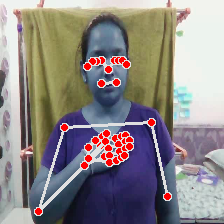

<Figure size 2000x2000 with 0 Axes>

In [13]:
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True)
hands = mp_hands.Hands(static_image_mode=True)

plt.figure(figsize=(20,20))
# video_file_name = os.listdir(f'/content/drive/MyDrive/sign_lang_dataset/please')
# selected_video = random.choice(video_file_name)
video_path = f'/content/drive/MyDrive/sign_lang_dataset/please/9.mp4'
cap = cv2.VideoCapture(video_path)
_,bgr_frame = cap.read()
cap.release()
bgr_frame = cv2.resize(bgr_frame,(224,224))
rgb_frame = cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
results = pose.process(rgb_frame)
hand_results = hands.process(rgb_frame)


pose_results = pose.process(rgb_frame)
hand_results = hands.process(rgb_frame)

if pose_results.pose_landmarks:
    mp_drawing.draw_landmarks(rgb_frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

if hand_results.multi_hand_landmarks:
    for hand_landmarks in hand_results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(rgb_frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

cv2_imshow( rgb_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()
# else:
#     print("No pose detected.")


In [ ]:
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

pose = mp_pose.Pose(static_image_mode=True)
hands = mp_hands.Hands(static_image_mode=True)

img = cv2.imread('/content/drive/MyDrive/test2.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pose_results = pose.process(img_rgb)
hand_results = hands.process(img_rgb)

if pose_results.pose_landmarks:
    mp_drawing.draw_landmarks(img, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

if hand_results.multi_hand_landmarks:
    for hand_landmarks in hand_results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(img, hand_landmarks, mp_hands.HAND_CONNECTIONS)

cv2_imshow(img)
